# Refining cluster annotation based on known marker genes

In [1]:
import custom_functions_scviEnv as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import warnings

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, 
                     fontsize=14, figsize=None, color_map=None, format='png', facecolor=None, 
                     transparent=False, ipython_format='png2x')

In [2]:
warnings.filterwarnings("ignore")

## Loading Data

In [3]:
adata = sc.read_h5ad('../data/taPVAT_8W_24W_M_F_HF_CTRL_combined_scANVI.h5ad')
adata

AnnData object with n_obs × n_vars = 71813 × 2000
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', 'diet', 'time', 'sex', 'batch', 'sample_type', 'rat_id', 'weight_3W', 'weight_10W', 'weight_17W', 'weight_24W', 'MAP_7W', 'systolic_bp_7W', 'MAP_9W', 'systolic_bp_9W', 'MAP_16W', 'systolic_bp_16W', 'MAP_24W', 'systolic_bp_24W', 'doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'celltype', 'random_state_0', 'random_state_1', 'random_state_2', 'random_state_3', 'random_state_4', 'random_state_5', 'leiden0.6', 'leiden0.8', 'leiden1.0', 'leiden1.2', 'leiden1.4', 'leiden1.6', 'leiden1.8', 'leiden2.0'
    var: 'gene_ids', '

In [4]:
adata.layers['raw_counts'].sum()

29114024.0

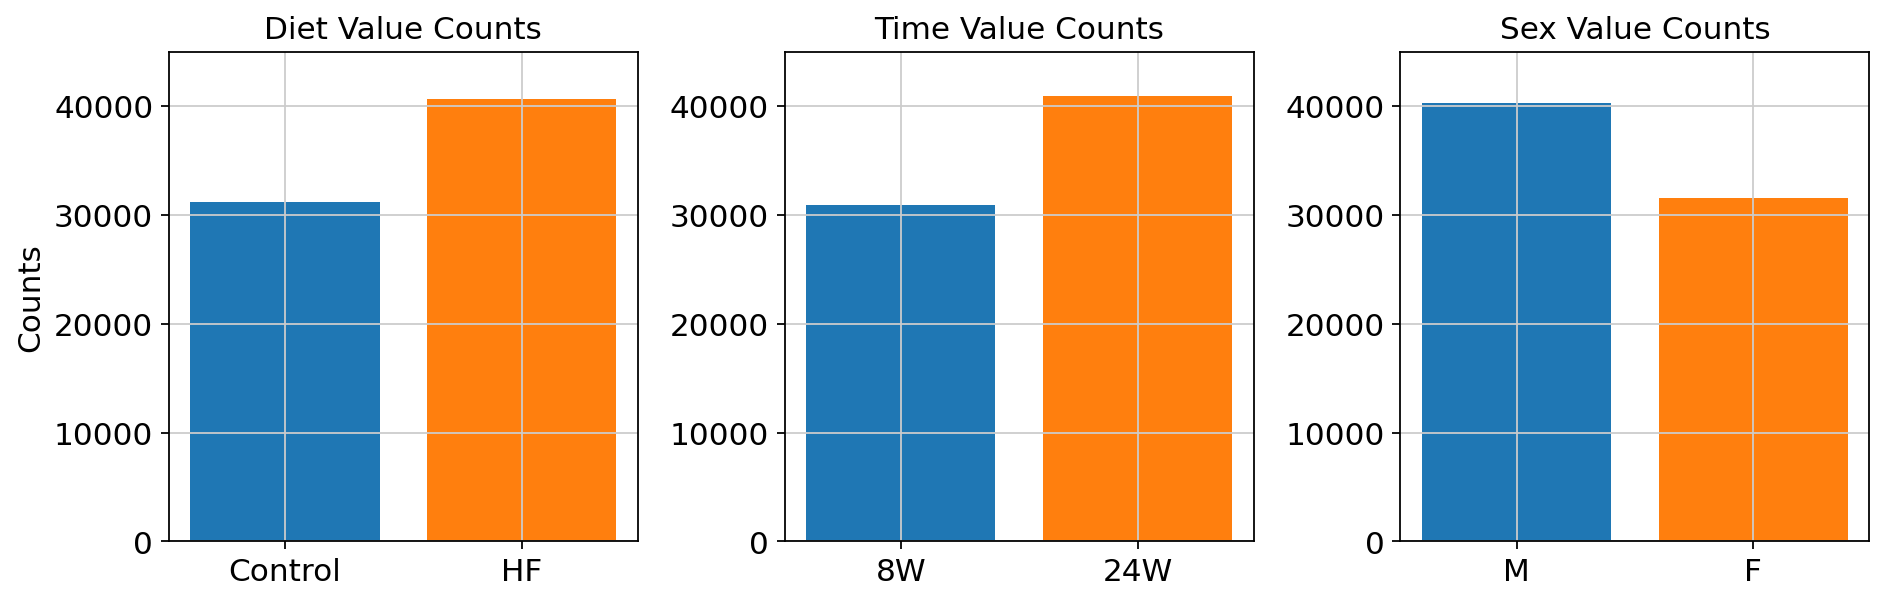

In [10]:
fig = plt.figure(figsize = (12,4))

gs = fig.add_gridspec(ncols=3, nrows=1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

value_counts = adata.obs.diet.value_counts()
value_counts = value_counts.reindex(['Control', 'HF'])
ax1.bar(value_counts.index, value_counts.values, color = ['C0', 'C1'])
ax1.set_title('Diet Value Counts')
ax1.set_ylabel('Counts')
ax1.set_ylim(0, 45000)

value_counts = adata.obs.time.value_counts()
value_counts = value_counts.reindex(['8W', '24W'])
ax2.bar(value_counts.index, value_counts.values, color = ['C0', 'C1'])
ax2.set_title('Time Value Counts')
ax2.set_ylim(0, 45000)

value_counts = adata.obs.sex.value_counts()
ax3.bar(value_counts.index, value_counts.values, color = ['C0', 'C1'])
ax3.set_title('Sex Value Counts')
ax3.set_ylim(0, 45000)

plt.tight_layout()

plt.savefig("taPVAT_bargraph_variables_counts.png", bbox_inches = "tight")
plt.show()

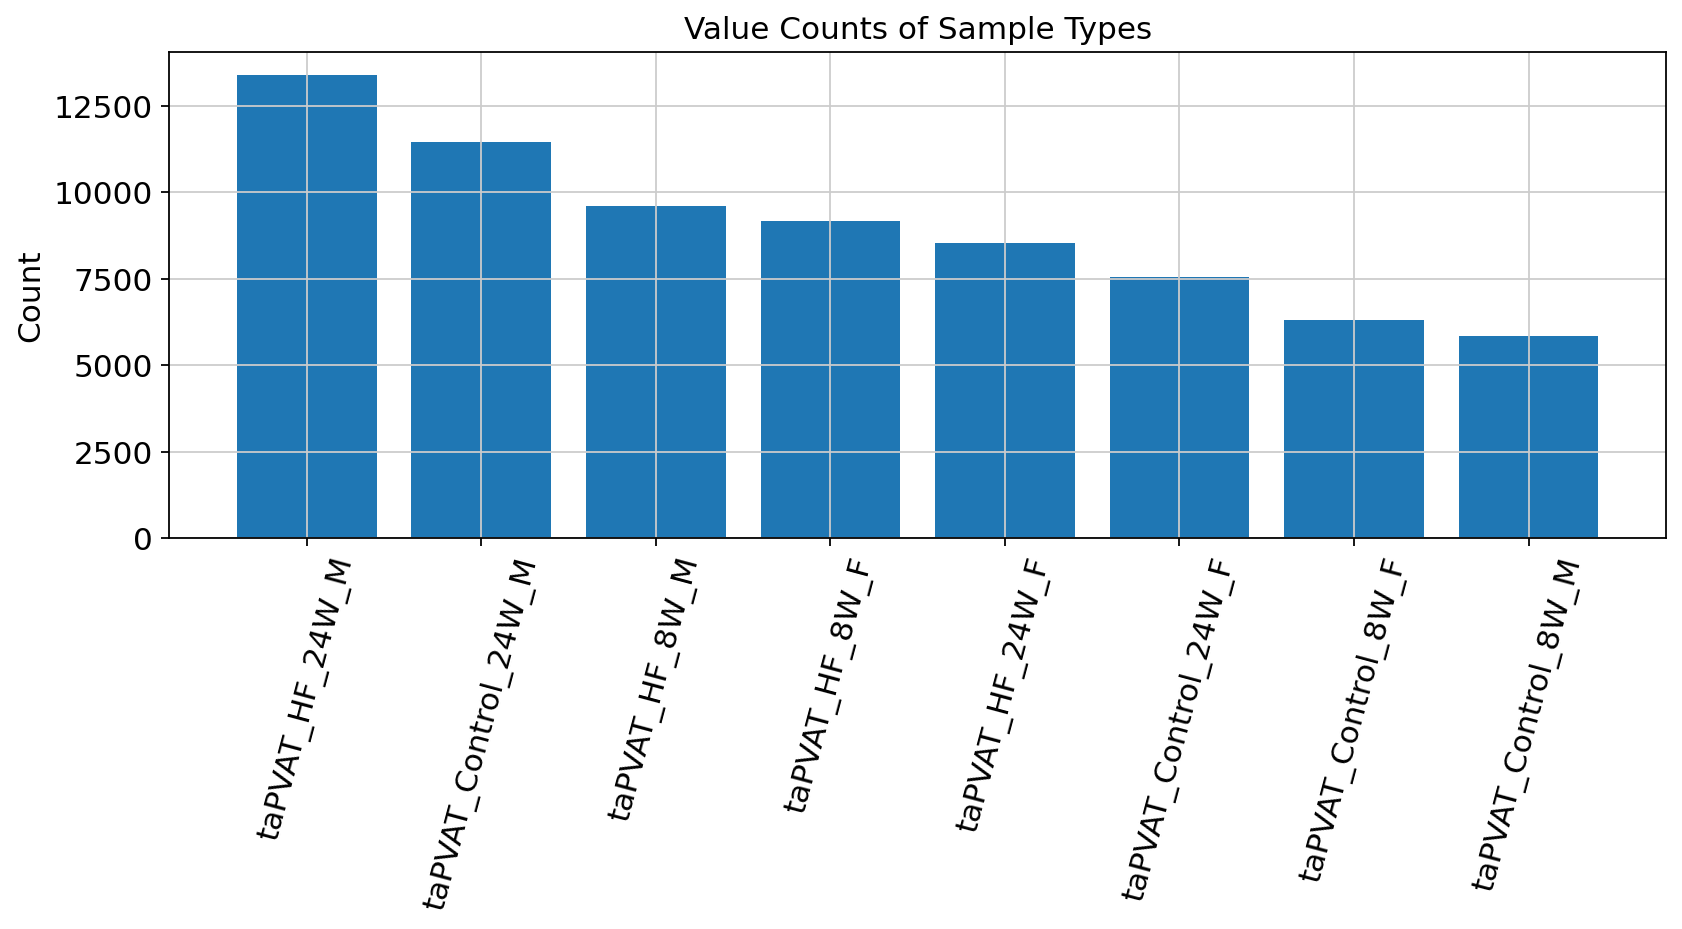

In [11]:
fig, ax = plt.subplots(ncols = 1, figsize = (12,4))

value_counts = adata.obs.sample_type.value_counts()

# Create a bar chart
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=75)

# Add labels and title
plt.xlabel('')
plt.ylabel('Count')
plt.title('Mean Value Counts of Sample Types')

# Show the plot
plt.savefig("taPVAT_bargraph_sample_types_mean_counts.png", bbox_inches = "tight")
plt.show()

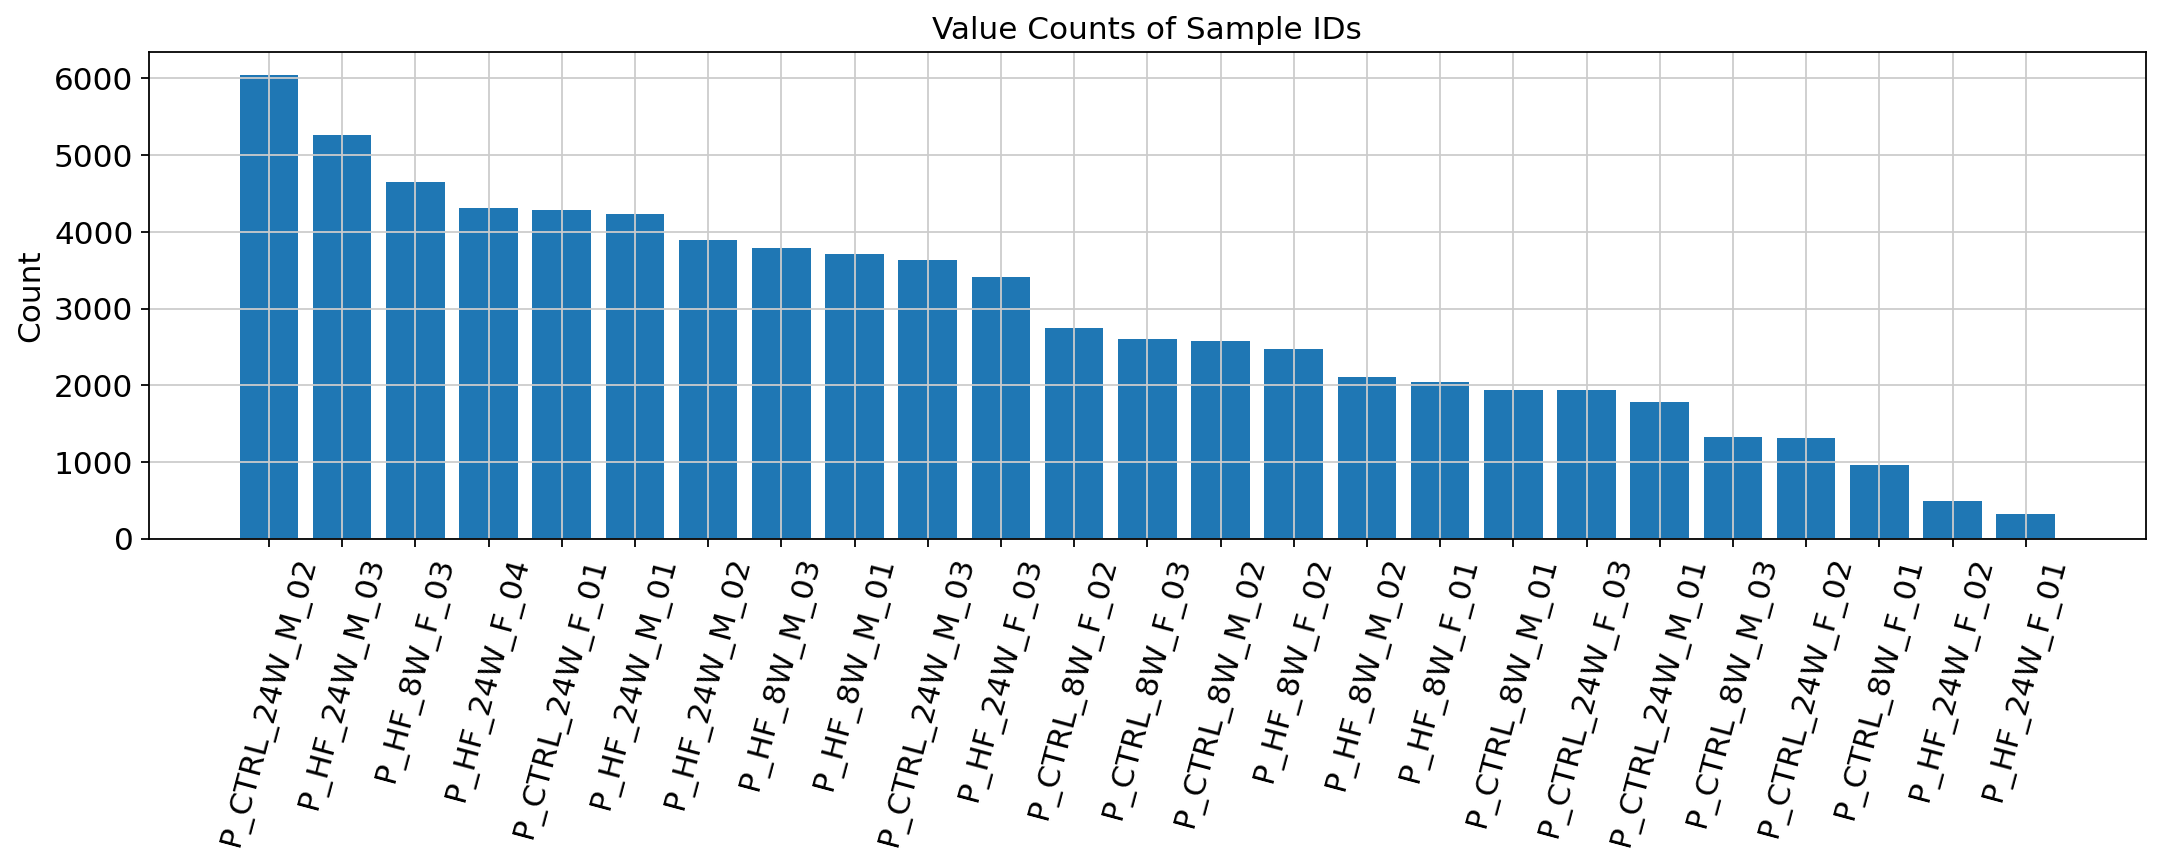

In [15]:
fig, ax = plt.subplots(ncols = 1, figsize = (16,4))

value_counts = adata.obs.sample_id.value_counts()

# Create a bar chart
plt.bar(value_counts.index, value_counts.values)
plt.xticks(rotation=75)

# Add labels and title
plt.xlabel('')
plt.ylabel('Count')
plt.title('Value Counts of Sample IDs')

# Show the plot
plt.savefig("taPVAT_bargraph_sample_ids_counts.png", bbox_inches = "tight")
plt.show()

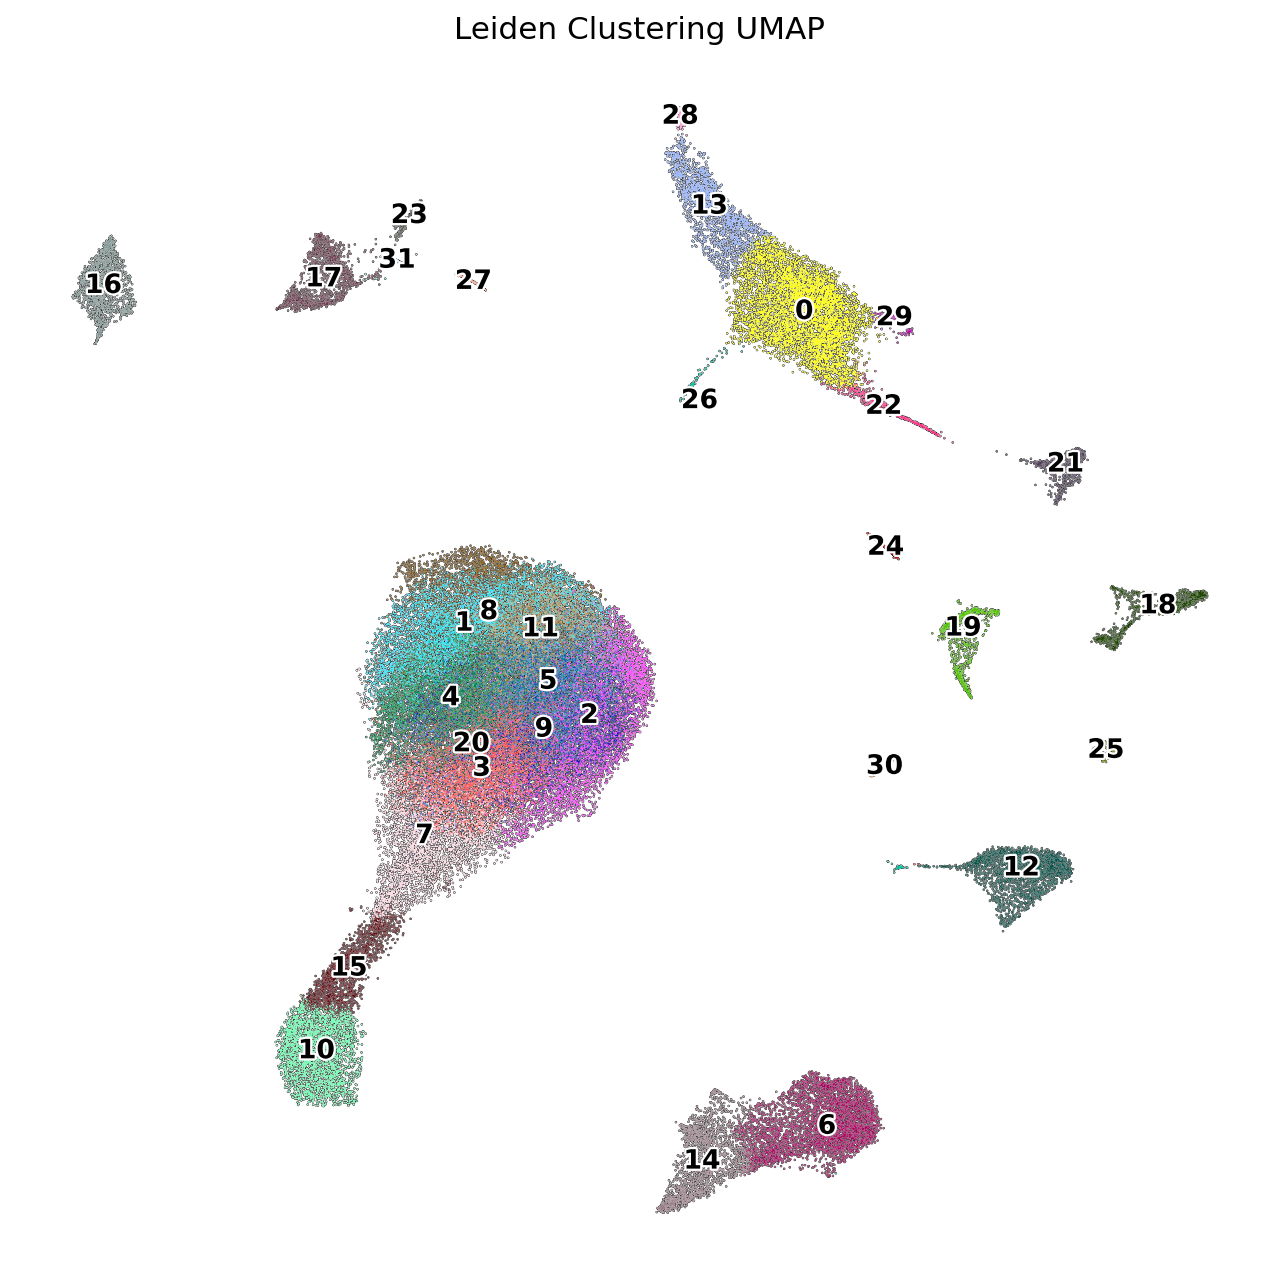

In [9]:
fig, ax = plt.subplots(ncols = 1, figsize = (10,10))
sc.pl.umap(adata, ax = ax, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title = 'Leiden Clustering UMAP')

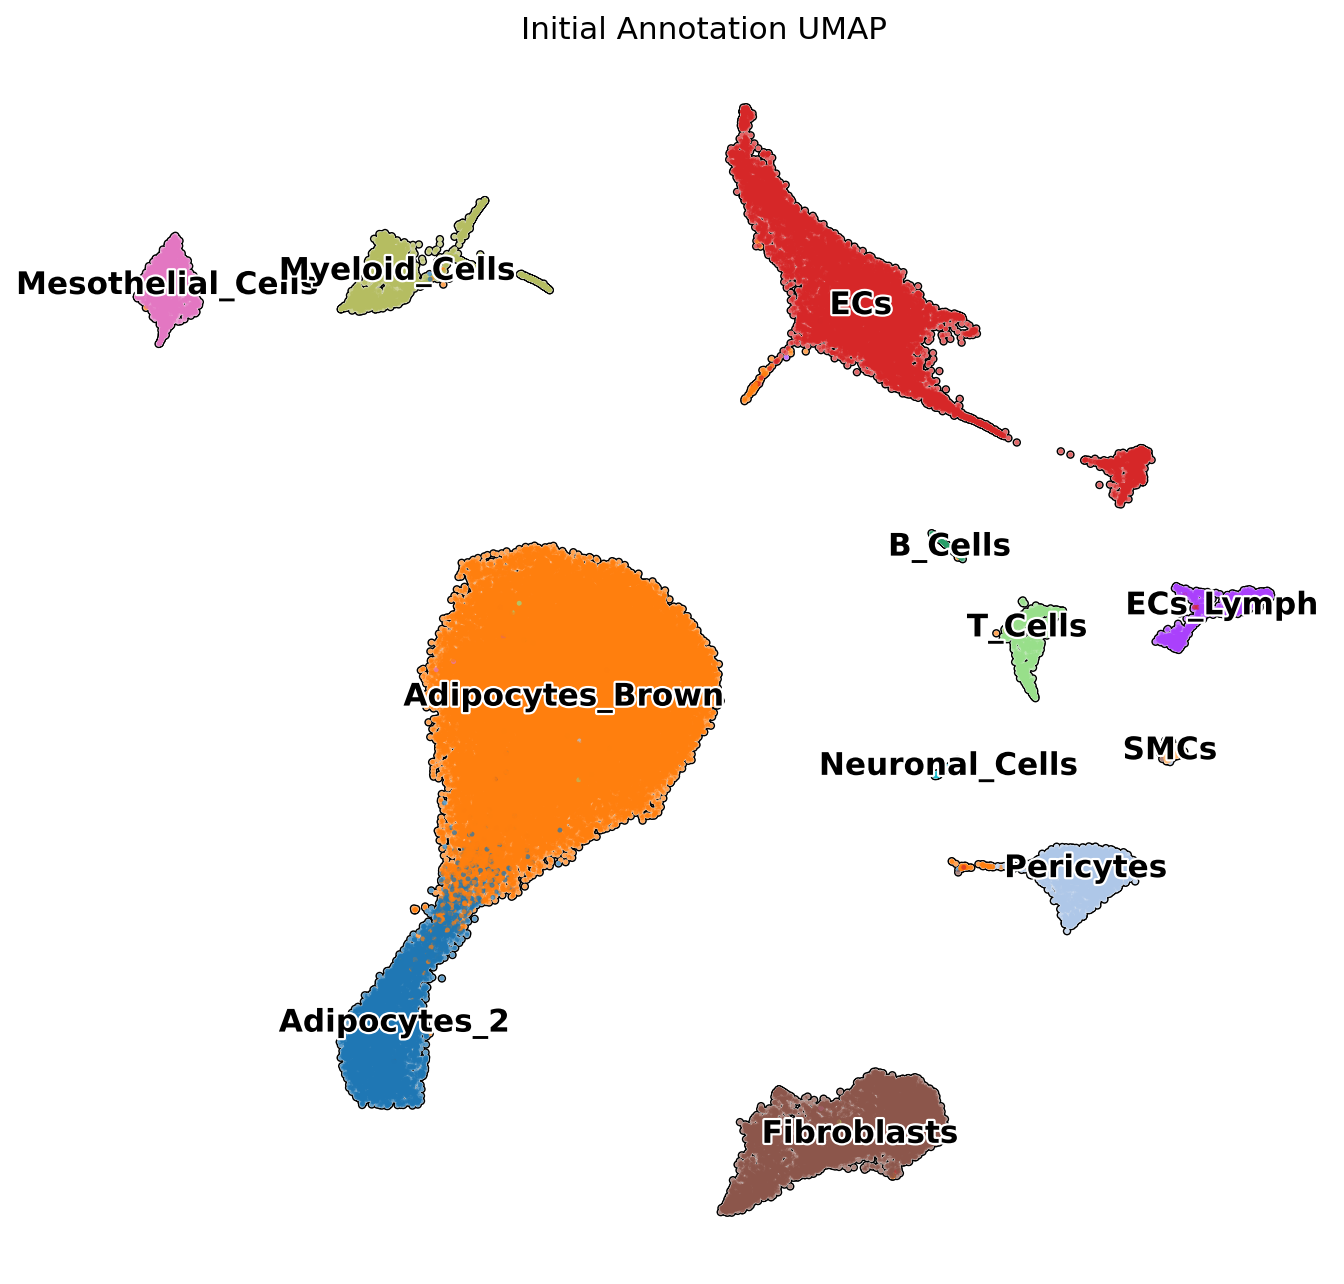

In [10]:
###Plotting single graph of all cells
fig, ax = plt.subplots(figsize = (10,10))
sc.pl.umap(adata, ax = ax, color='celltype', add_outline=True, size = 20, 
        legend_loc='on data', legend_fontsize=14, legend_fontoutline=2,frameon=False,
        title='Initial Annotation UMAP')
plt.show()

## Creating a matrix plot from leiden clusters

In [11]:
## May need to run this to get rank_genes_groups to work
adata.uns['log1p']["base"] = None

In [12]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method='wilcoxon', use_raw = True, tie_correct = True, pts = True)

In [13]:
sc.tl.dendrogram(adata, groupby = 'leiden')

         Falling back to preprocessing with `sc.pp.pca` and default params.


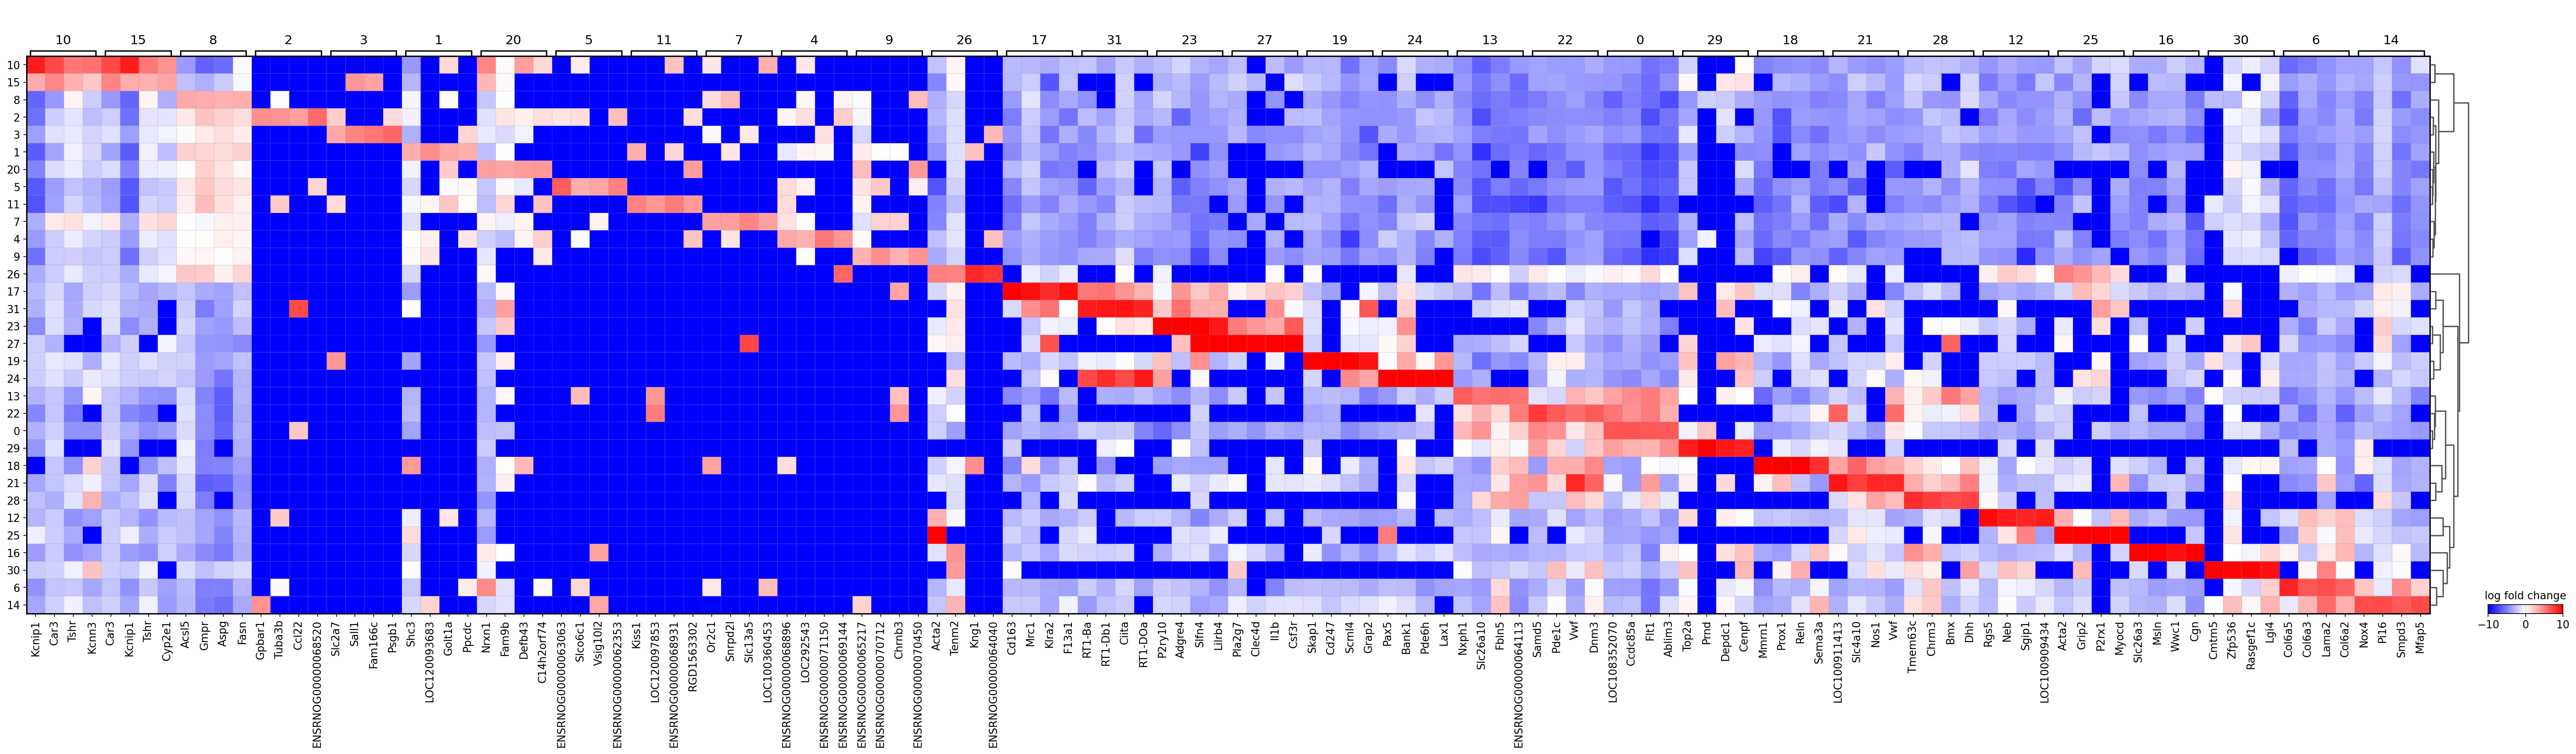

In [14]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-10,
    vmax=10,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    save = '../output/taPVAT_matrixplot_rank_genes_groups_leiden.png'
)

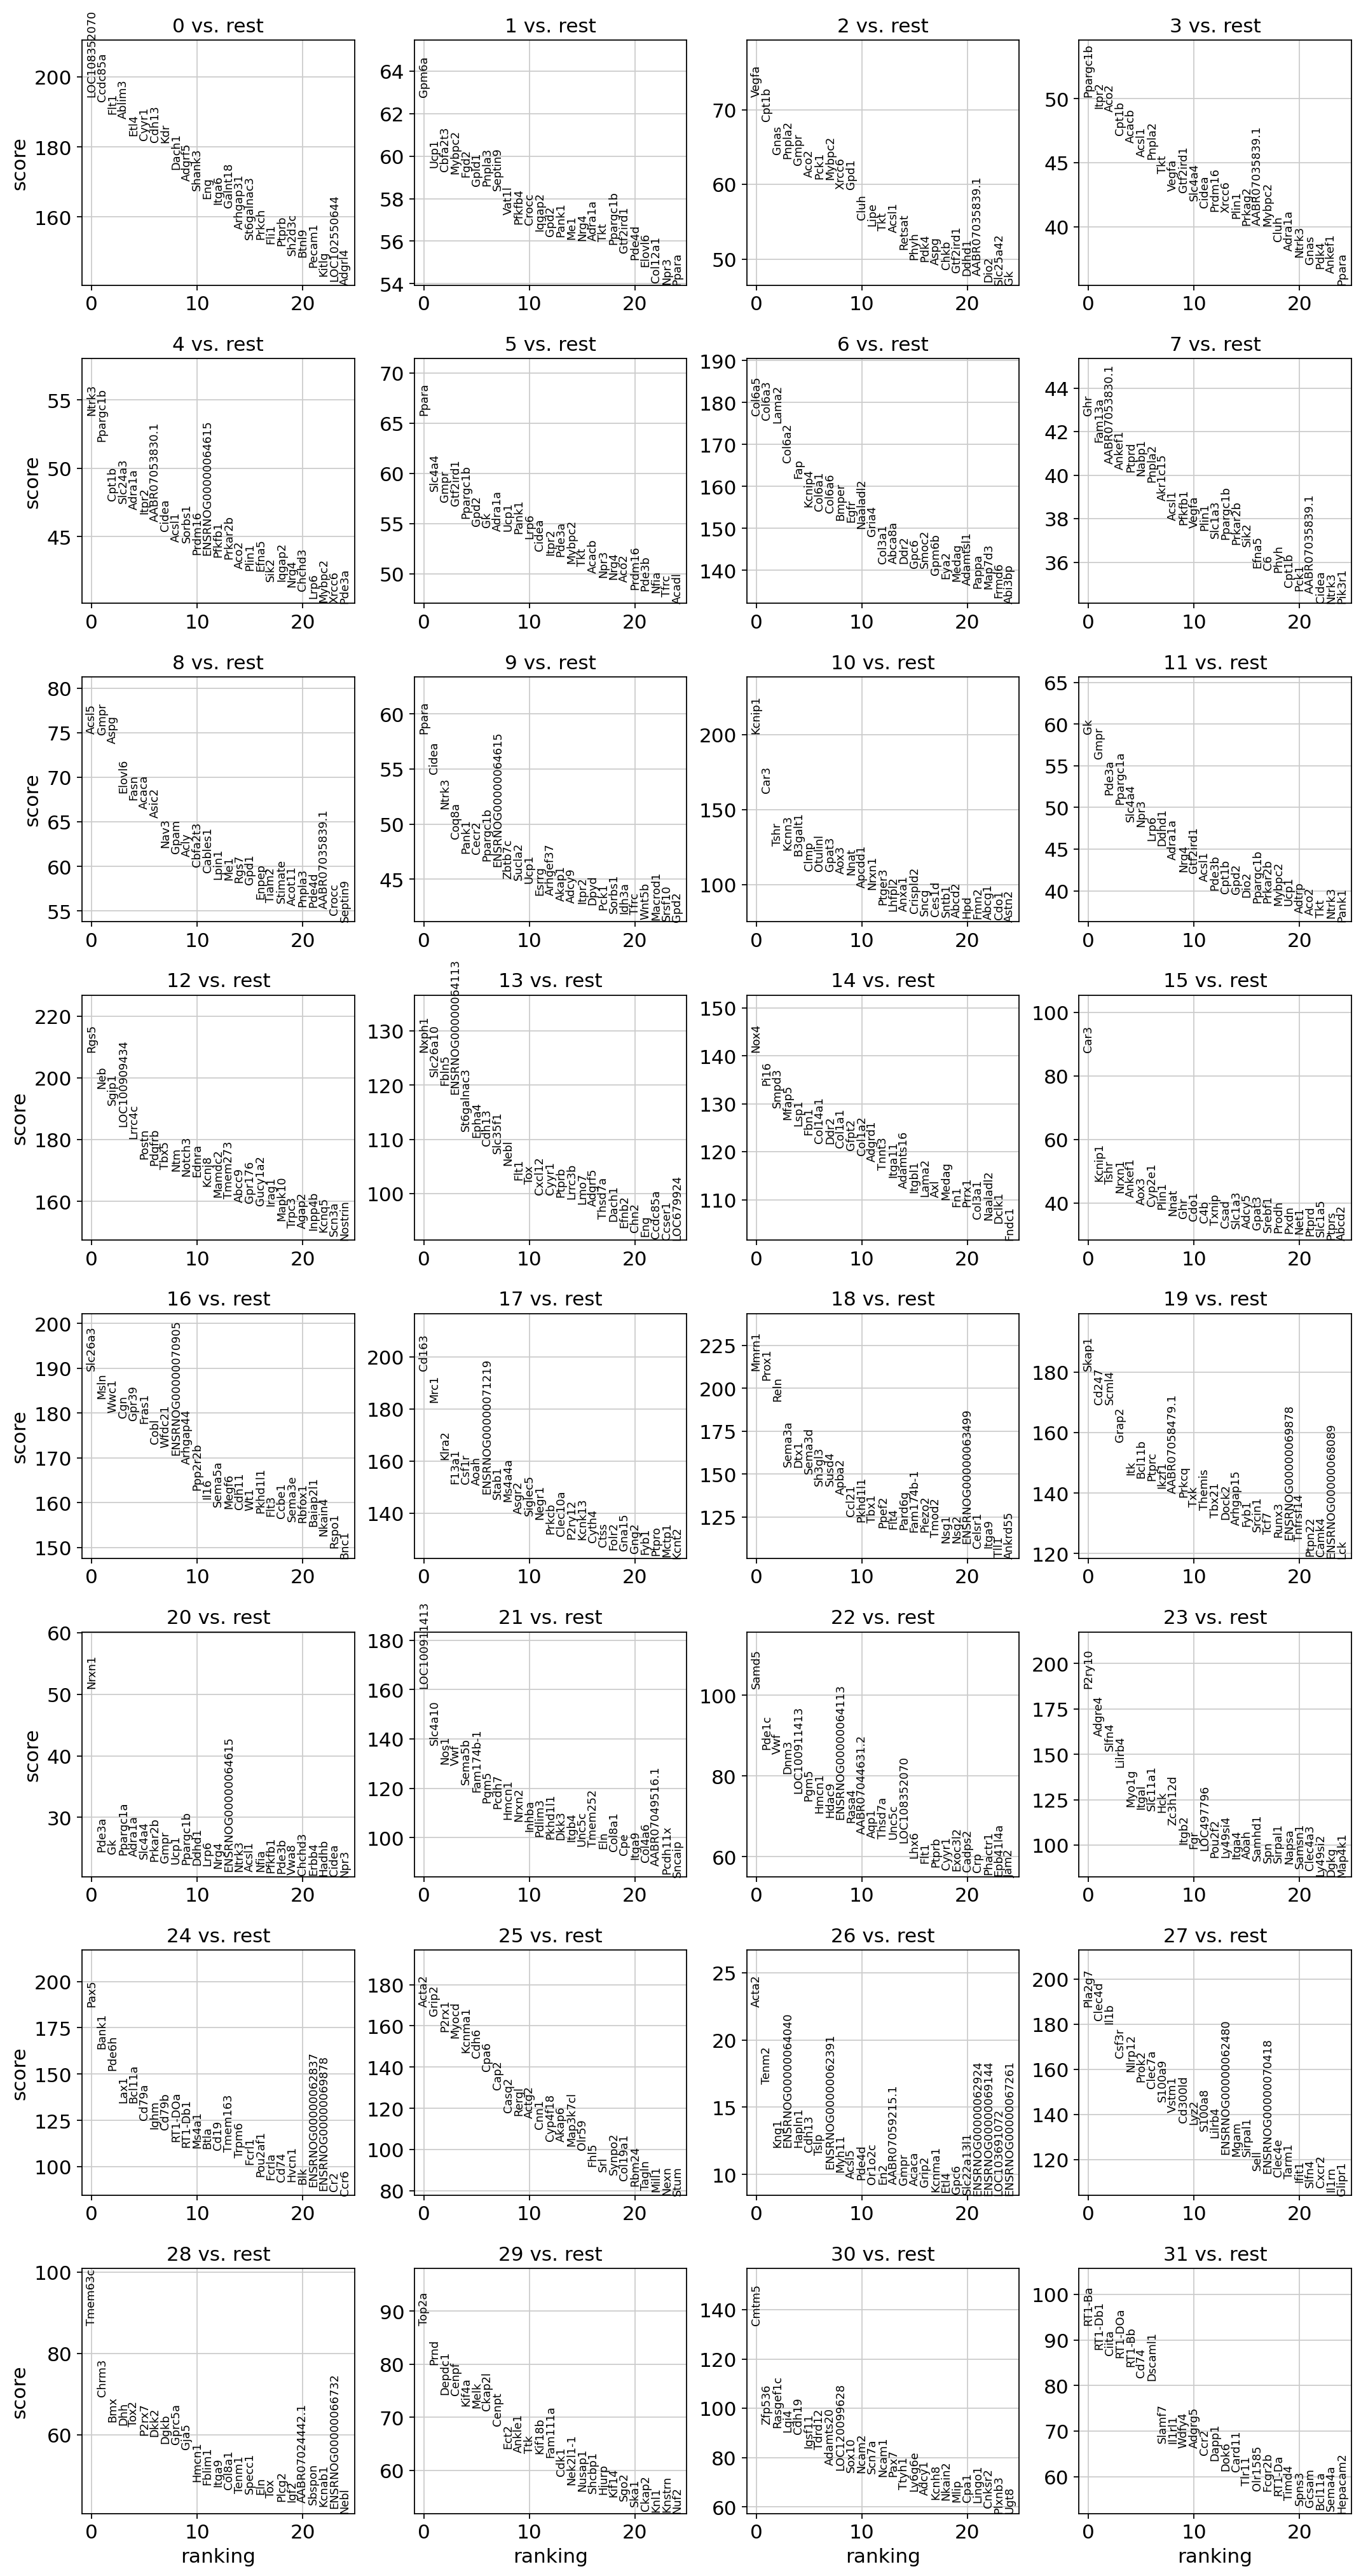

In [15]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25).to_csv('../output/taPVAT_rank_genes_groups_leiden.csv')

## Labeling the leiden clusters

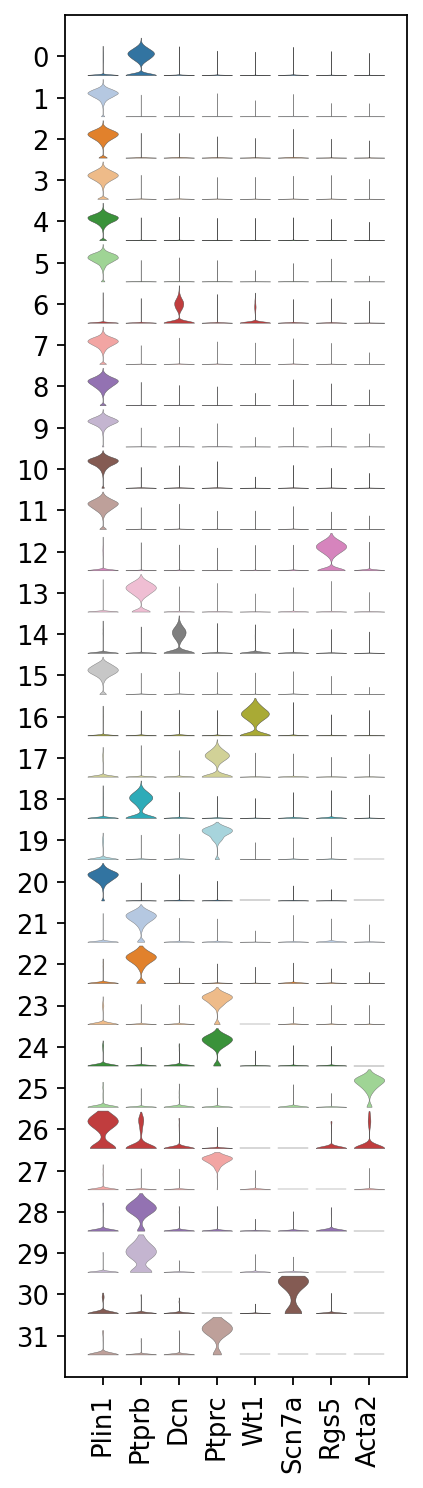

In [16]:
### Violin plot of gene expression for labeling "high-level" cell-types
mgl = ["Plin1",  #Adipocytes
       "Ptprb",  #Endothelial_Cells
       "Dcn",    #Fibroblasts
       "Ptprc",  #Immune_Cells
       "Wt1",    #Mesothelial_Cells
       "Scn7a",  #Neuronal_Cells
       "Rgs5",   #Pericytes
       "Acta2"   #SMCs
]

ax = sc.pl.stacked_violin(adata, 
                          mgl, 
                          use_raw = True,
                          groupby='leiden', 
                          swap_axes = False, 
                          row_palette = 'tab20')

In [17]:
### Assigning high-level cell type annotations to leiden clusters

def celltype_broad_map(x):
    if x in ['0', '13', '18', '21', '22', '28', '29']:
        return 'Endothelial_Cells'
    elif x in ['6', '14']:
        return 'Fibroblasts'
    elif x == '12':
        return 'Pericytes'
    elif x in ['17', '19', '23', '24', '27', '31']:
        return 'Immune_Cells'
    elif x == '16':
        return 'Mesothelial_Cells'
    elif x == '25':
        return 'SMCs'
    elif x == '30':
        return 'Neuronal_Cells'
    else:
        return 'Adipocytes'
    
adata.obs['celltype_broad'] = adata.obs.leiden.map(celltype_broad_map)
adata.obs['celltype_broad'].value_counts()    
    

Adipocytes           46067
Endothelial_Cells    11461
Fibroblasts           6684
Immune_Cells          3343
Pericytes             2419
Mesothelial_Cells     1546
SMCs                   185
Neuronal_Cells         108
Name: celltype_broad, dtype: int64

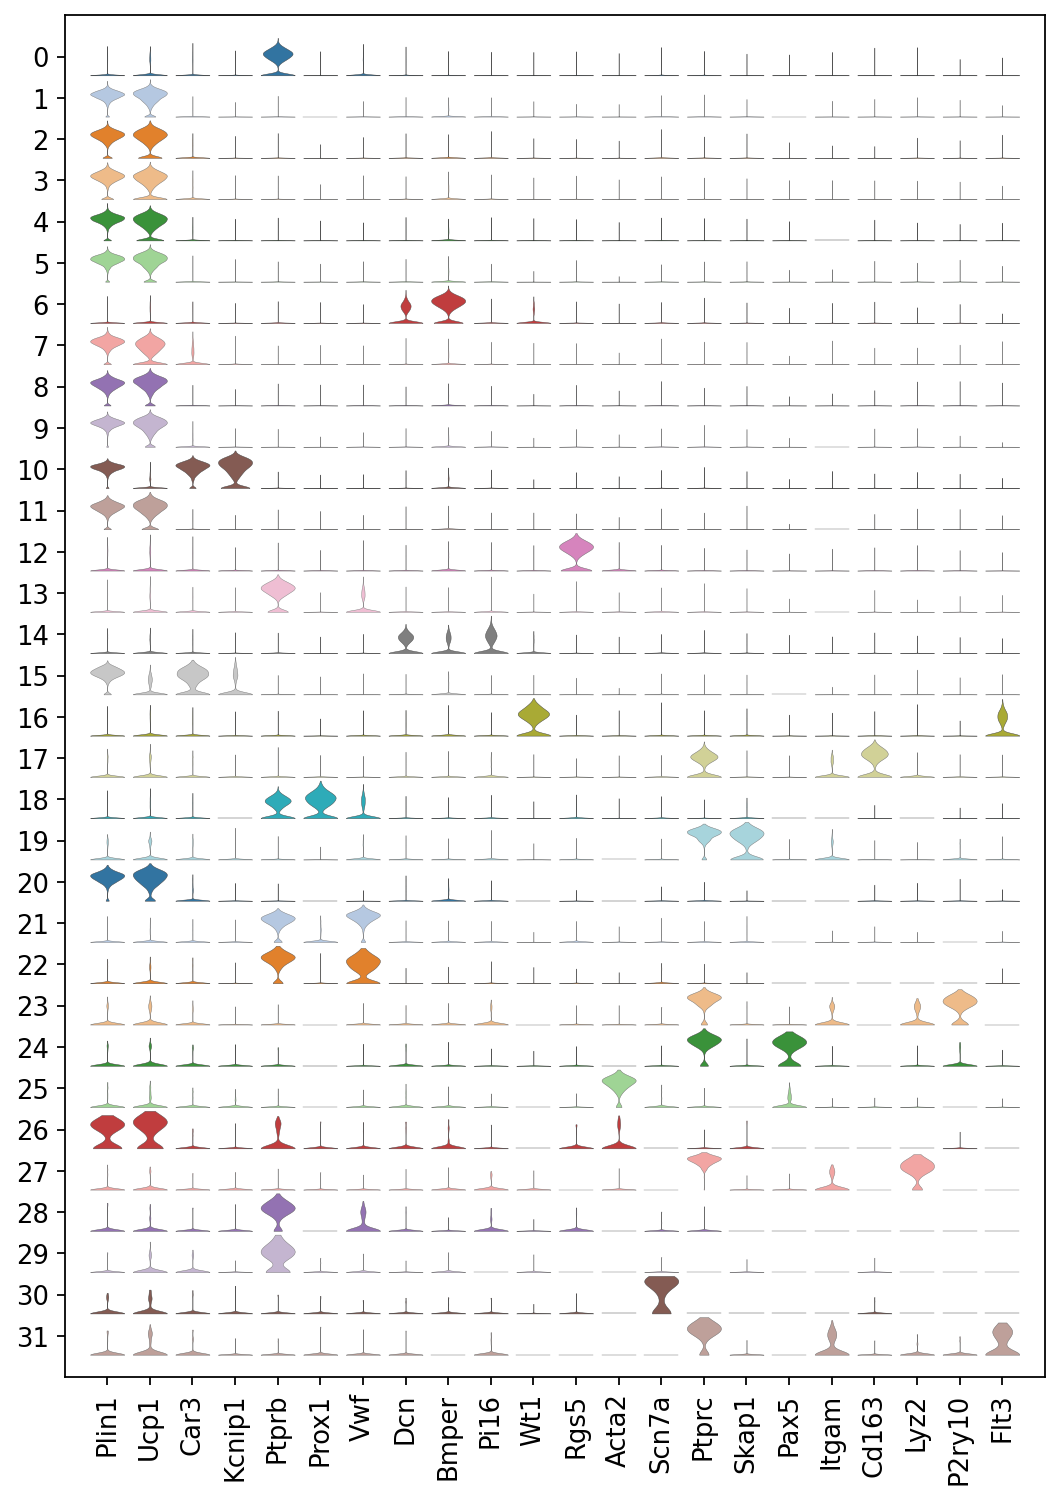

In [18]:
### Violin plot of gene expression for labeling "low-level" cell-types
mgl = ["Plin1",             #Adipocytes
       "Ucp1",              #Adipocytes_Brown
       "Car3",              #Adipocytes_2 
       "Kcnip1",            #Adipocytes_3
       "Ptprb",             #Endothelial_Cells (ECs)
       "Prox1",             #ECs_Lymph
       "Vwf",               #ECs_Venous
       "Dcn",               #Fibroblasts
       "Bmper",             #Fibroblasts_Bmper+
       "Pi16",              #Fibroblasts_Pi16+
       "Wt1",               #Mesothelial_Cells
       "Rgs5",              #Pericytes
       "Acta2",             #Smooth_Muscle_Cells (SMCs)
       "Scn7a",             #Neuronal_Cells
       "Ptprc",             #Immune_Cells
       "Skap1",             #T_Cells
       "Pax5",              #B_Cells
       "Itgam",             #Myeloid_Cells
       "Cd163",             #Macrophages_M2
       "Lyz2",              #Macrophages_M1
       "P2ry10",            #Myeloid_Cells
       "Flt3"               #DCs
]

ax = sc.pl.stacked_violin(adata, 
                          mgl, 
                          use_raw = True,
                          groupby='leiden', 
                          swap_axes = False,
                          row_palette = 'tab20')

In [19]:
### Assigning low-level cell type annotations to leiden clusters
def cell_type_mapping(x):
    cell_type_dict = {
        '0': "ECs_1",
        '1': "Adipocytes_Brown",
        '2': "Adipocytes_Brown",
        '3': "Adipocytes_Brown",
        '4': "Adipocytes_Brown",
        '5': "Adipocytes_Brown",
        '6': "Fibroblasts_Bmper+",
        '7': "Adipocytes_Brown",
        '8': "Adipocytes_Brown",
        '9': "Adipocytes_Brown",
        '10': "Adipocytes_3",
        '11': "Adipocytes_Brown",
        '12': "Pericytes",
        '13': "ECs_1",
        '14': "Fibroblasts_Pi16+",
        '15': "Adipocytes_2",
        '16': "Mesothelial_Cells",
        '17': 'Macrophages_M2',
        '18': 'ECs_Lymph',
        '19': 'T_Cells',
        '20': 'Adipocytes_Brown',
        '21': 'ECs_Venous',
        '22': 'ECs_Venous',
        '23': 'Macrophages_M1_P2ry10+',
        '24': 'B_Cells',
        '25': 'SMCs',
        '26': 'Adipocytes_Brown',
        '27': 'Macrophages_M1',
        '28': 'ECs_Venous',
        '29': 'ECs_1',
        '30': 'Neuronal_Cells',
        '31': 'Dendritic_Cells'
    }

    return cell_type_dict.get(str(x), 'Unknown_Cell_Type')

adata.obs['celltype'] = adata.obs.leiden.map(cell_type_mapping)
print(adata.obs['celltype'].value_counts())


Adipocytes_Brown          41222
ECs_1                      8916
Fibroblasts_Bmper+         4531
Adipocytes_3               3052
Pericytes                  2419
Fibroblasts_Pi16+          2153
Adipocytes_2               1793
Mesothelial_Cells          1546
Macrophages_M2             1467
ECs_Venous                 1444
ECs_Lymph                  1101
T_Cells                     986
Macrophages_M1_P2ry10+      345
B_Cells                     282
SMCs                        185
Macrophages_M1              157
Neuronal_Cells              108
Dendritic_Cells             106
Name: celltype, dtype: int64


In [ ]:
###Plotting single graph of all high-level cells
fig, ax = plt.subplots(figsize = (10,10))
sc.pl.umap(adata, ax = ax, color='celltype_broad', add_outline=True, size = 20, 
        legend_loc='on data', legend_fontsize=14, legend_fontoutline=2,frameon=False,
        title='Leiden Clustering of Cells')
plt.show()

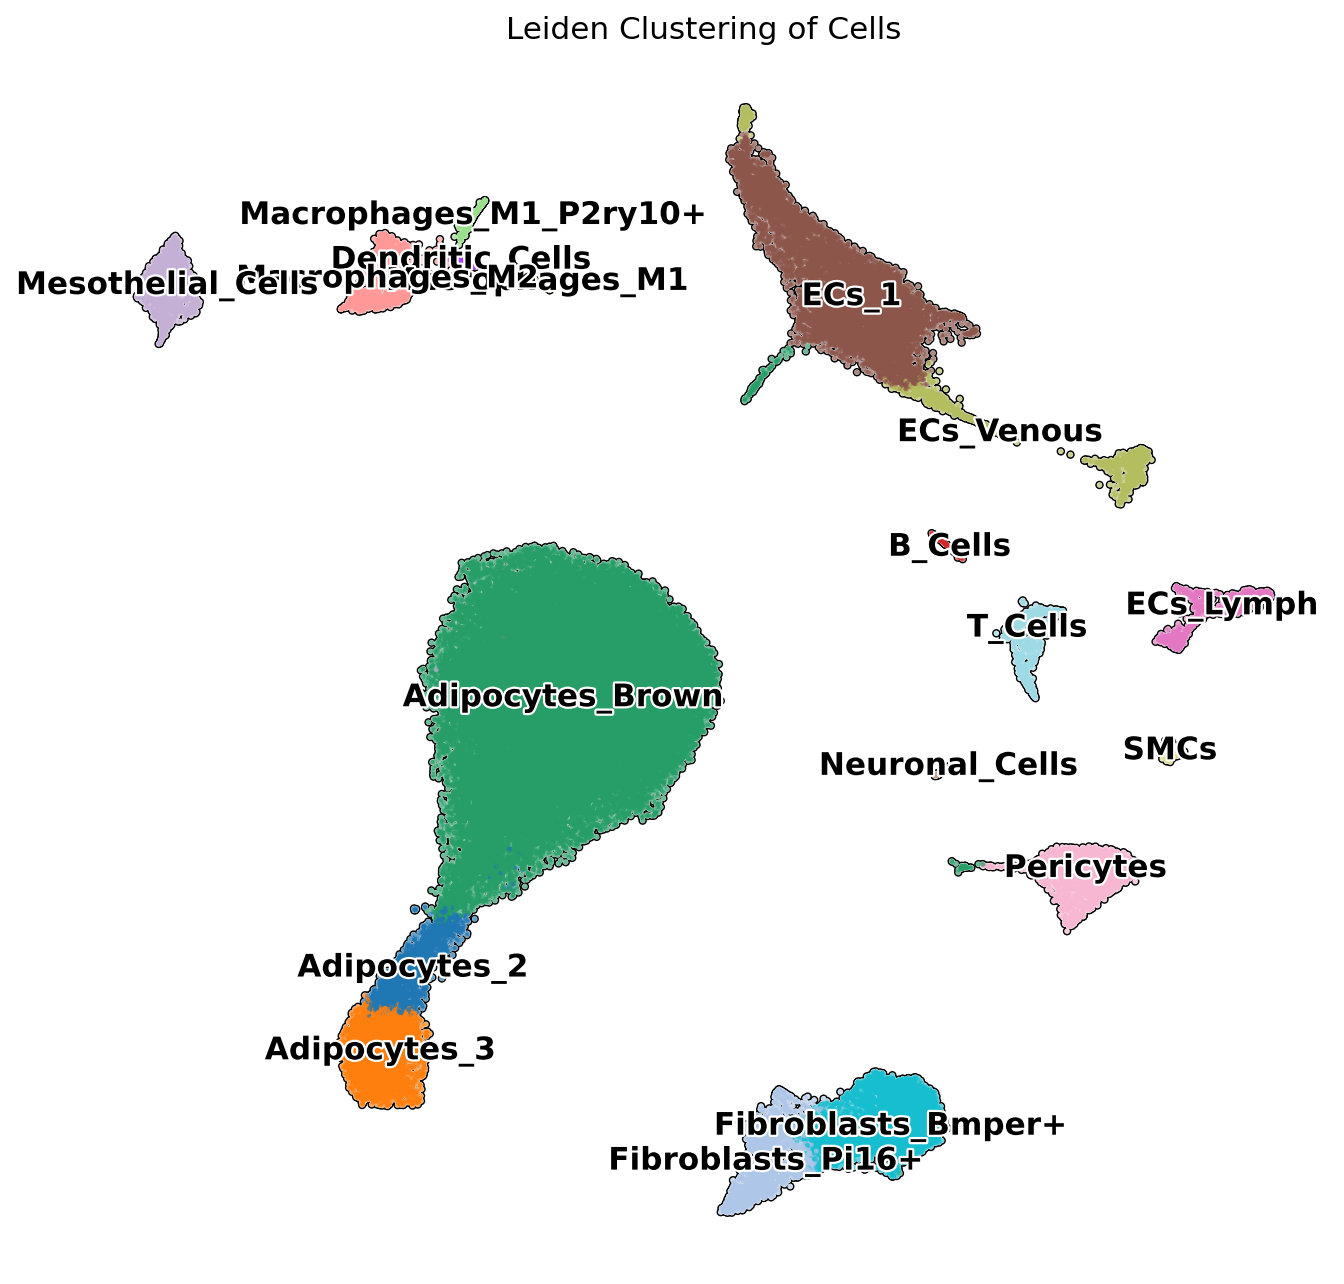

In [20]:
###Plotting single graph of all low-level cells
fig, ax = plt.subplots(figsize = (10,10))
sc.pl.umap(adata, ax = ax, color='celltype', add_outline=True, size = 20, 
        legend_loc='on data', legend_fontsize=14, legend_fontoutline=2,frameon=False,
        title='Leiden Clustering of Cells')
plt.show()

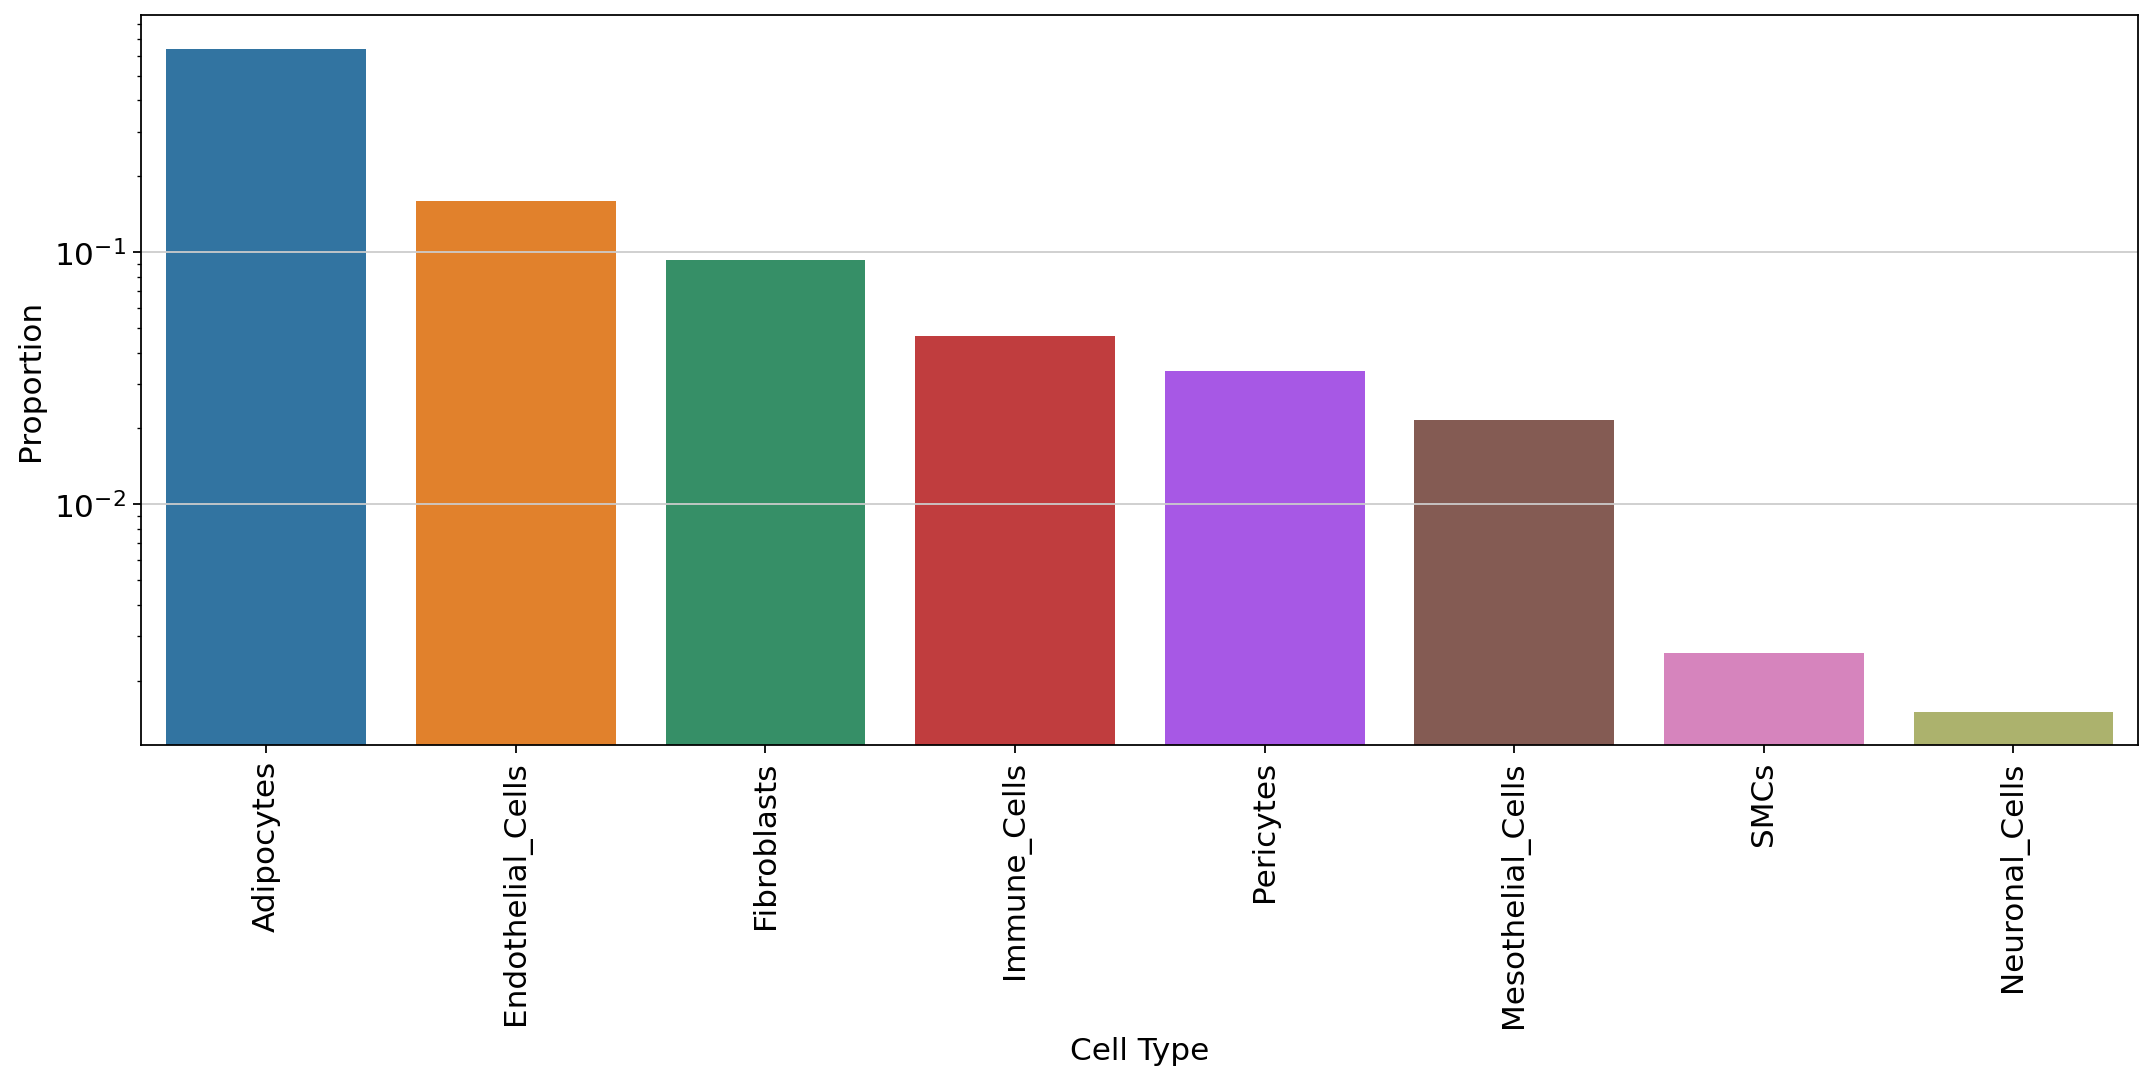

In [22]:
### Plotting the proportion of each high-level cell type
N = len(adata)
fig, ax = plt.subplots(figsize = (16,6))

props_dict = {"Cell Type":[], "Proportion":[]}
for i in np.unique(adata.obs.celltype_broad):
    i_len = len(adata[adata.obs.celltype_broad == i])
    props_dict["Cell Type"].append(i)
    props_dict["Proportion"].append(i_len/N)
props_df = pd.DataFrame(props_dict)

sns.barplot(x = "Cell Type", y = "Proportion", ax = ax, data = props_df, log = True, 
            order = props_df.sort_values("Proportion", ascending = False)["Cell Type"])
plt.xticks(rotation = 90)

plt.show()

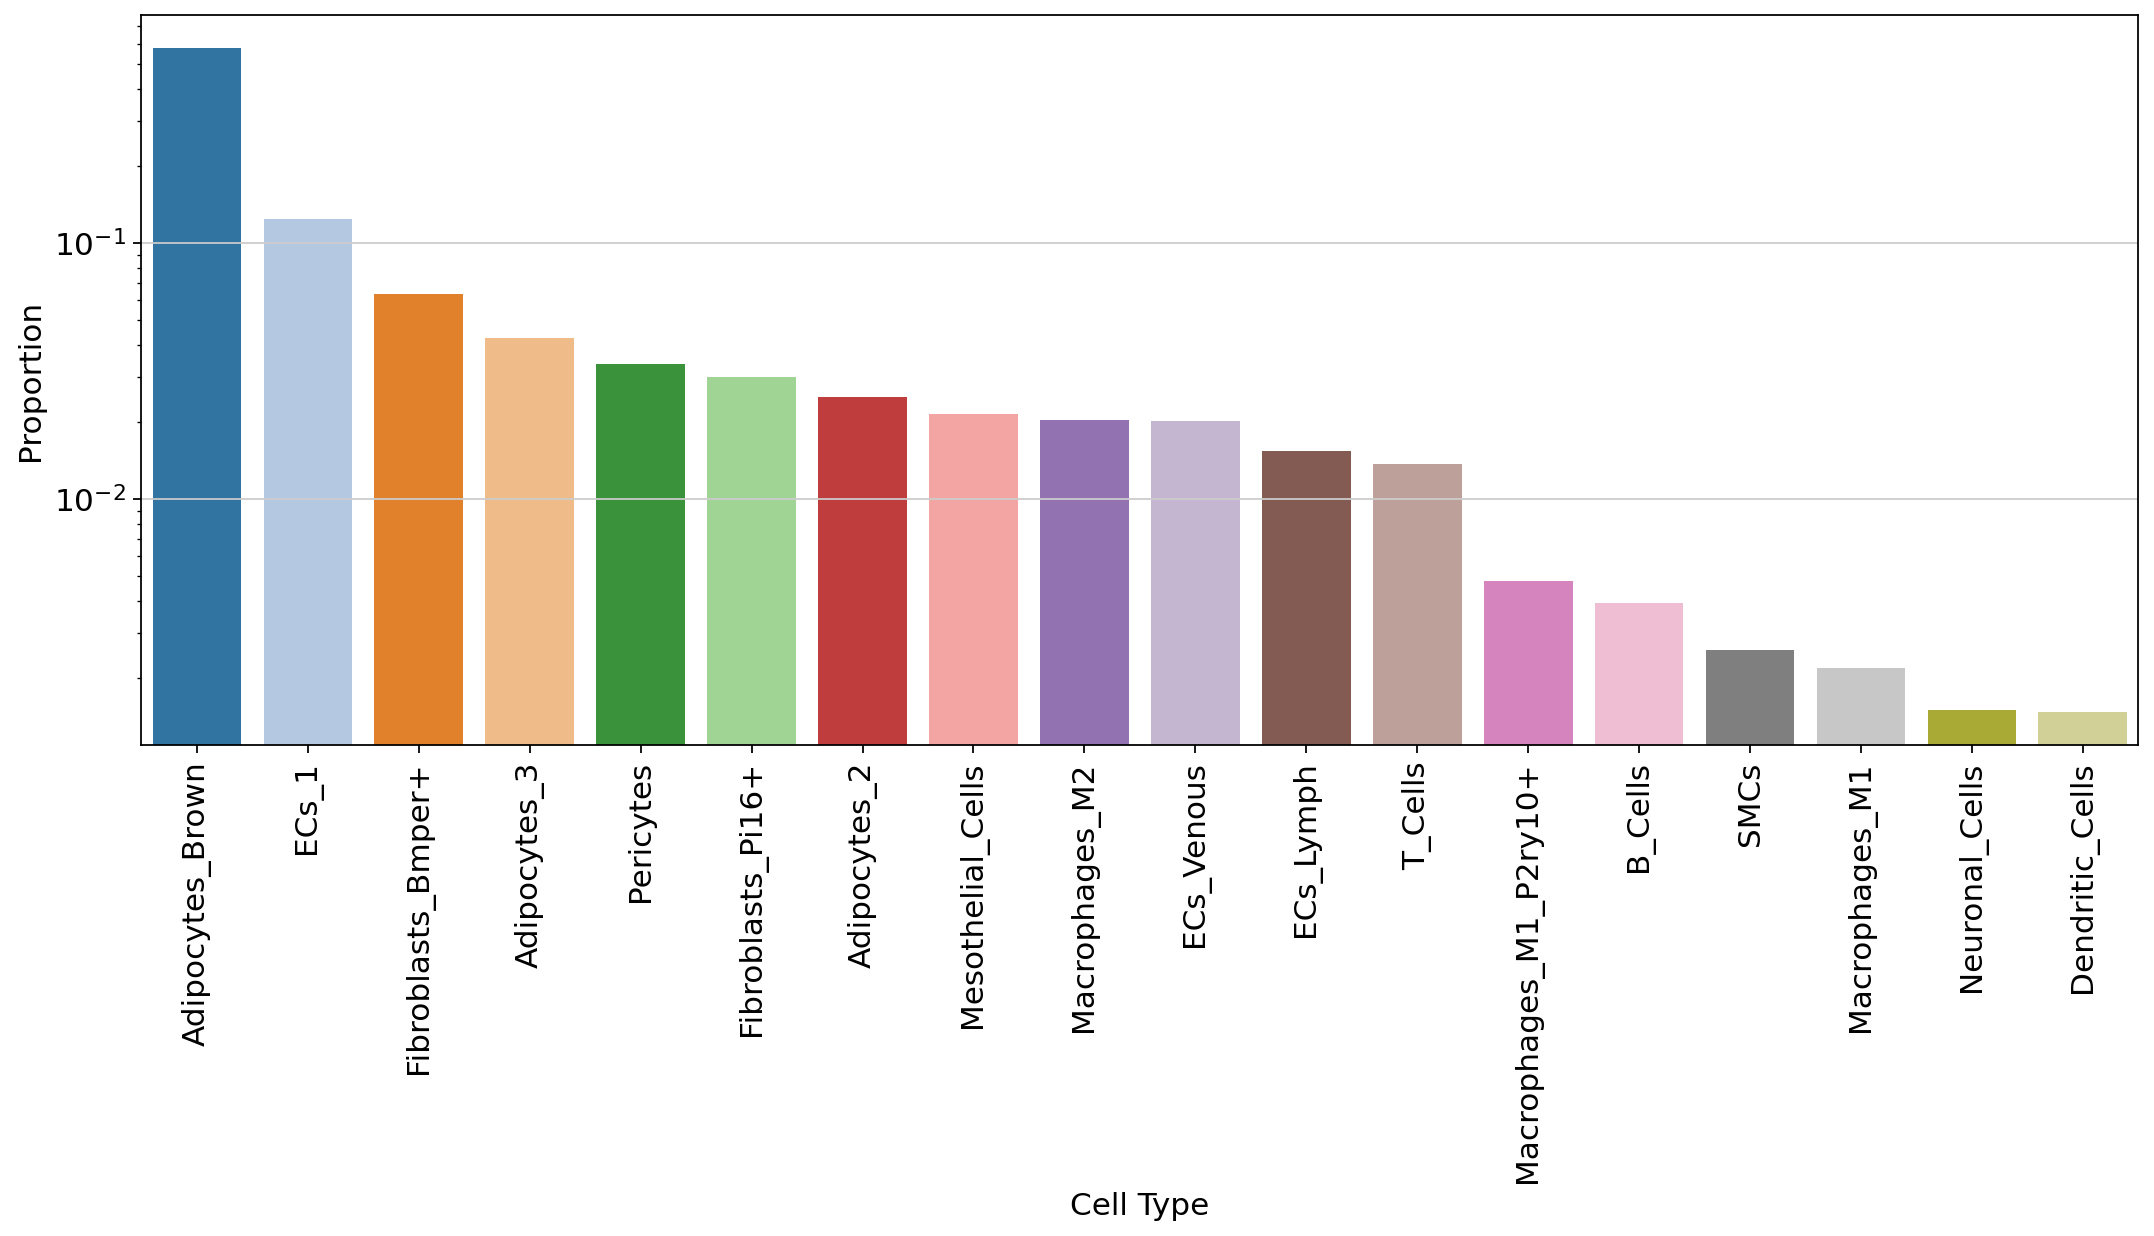

In [23]:
### Plotting the proportion of each low-level cell type
N = len(adata)
fig, ax = plt.subplots(figsize = (16,6))

props_dict = {"Cell Type":[], "Proportion":[]}
for i in np.unique(adata.obs.celltype):
    i_len = len(adata[adata.obs.celltype == i])
    props_dict["Cell Type"].append(i)
    props_dict["Proportion"].append(i_len/N)
props_df = pd.DataFrame(props_dict)

sns.barplot(x = "Cell Type", y = "Proportion", ax = ax, data = props_df, palette = "tab20", log = True, 
            order = props_df.sort_values("Proportion", ascending = False)["Cell Type"])
plt.xticks(rotation = 90)

plt.show()

## Double check that celltype labels are reasonable

In [24]:
## May need to run this to get rank_genes_groups to work
adata.uns['log1p']["base"] = None

In [25]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype', method='wilcoxon', use_raw = True, tie_correct = True, pts = True)

In [26]:
sc.tl.dendrogram(adata, groupby = 'celltype')

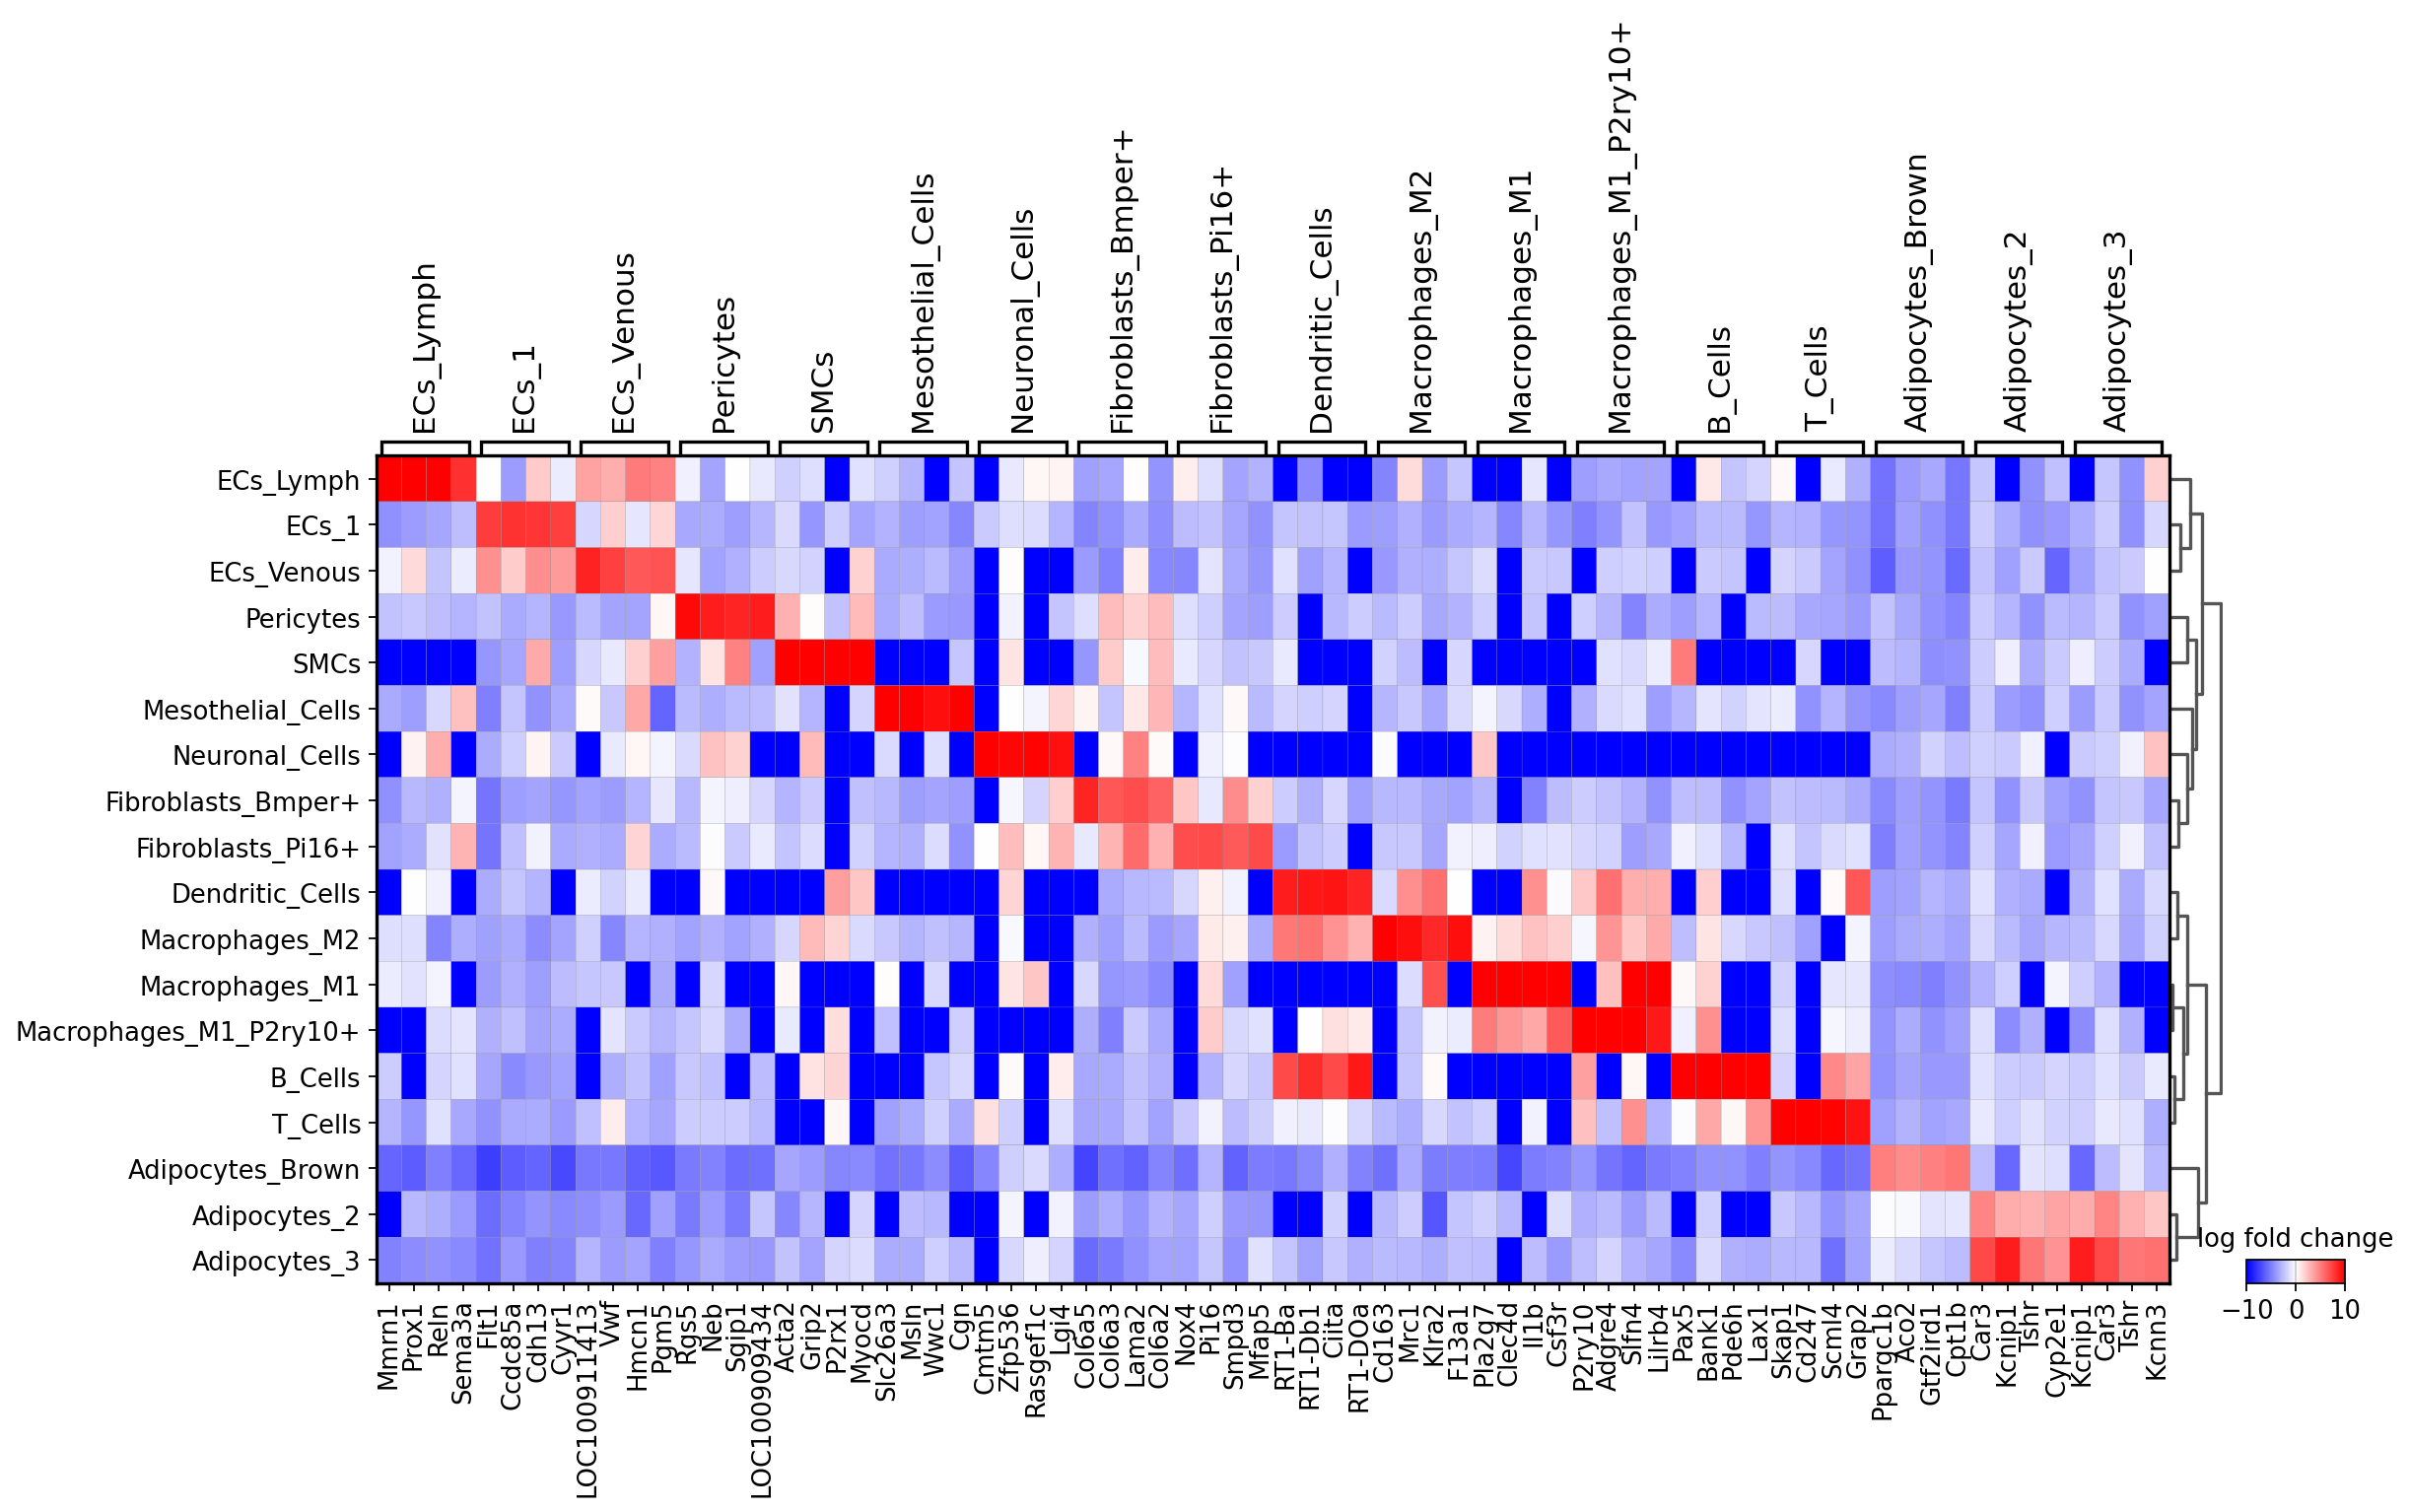

In [27]:
fig, ax = plt.subplots(figsize = (16,8))

sc.pl.rank_genes_groups_matrixplot(
    adata,
    ax = ax,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-10,
    vmax=10,
    min_logfoldchange=3,
    colorbar_title='log fold change'
)

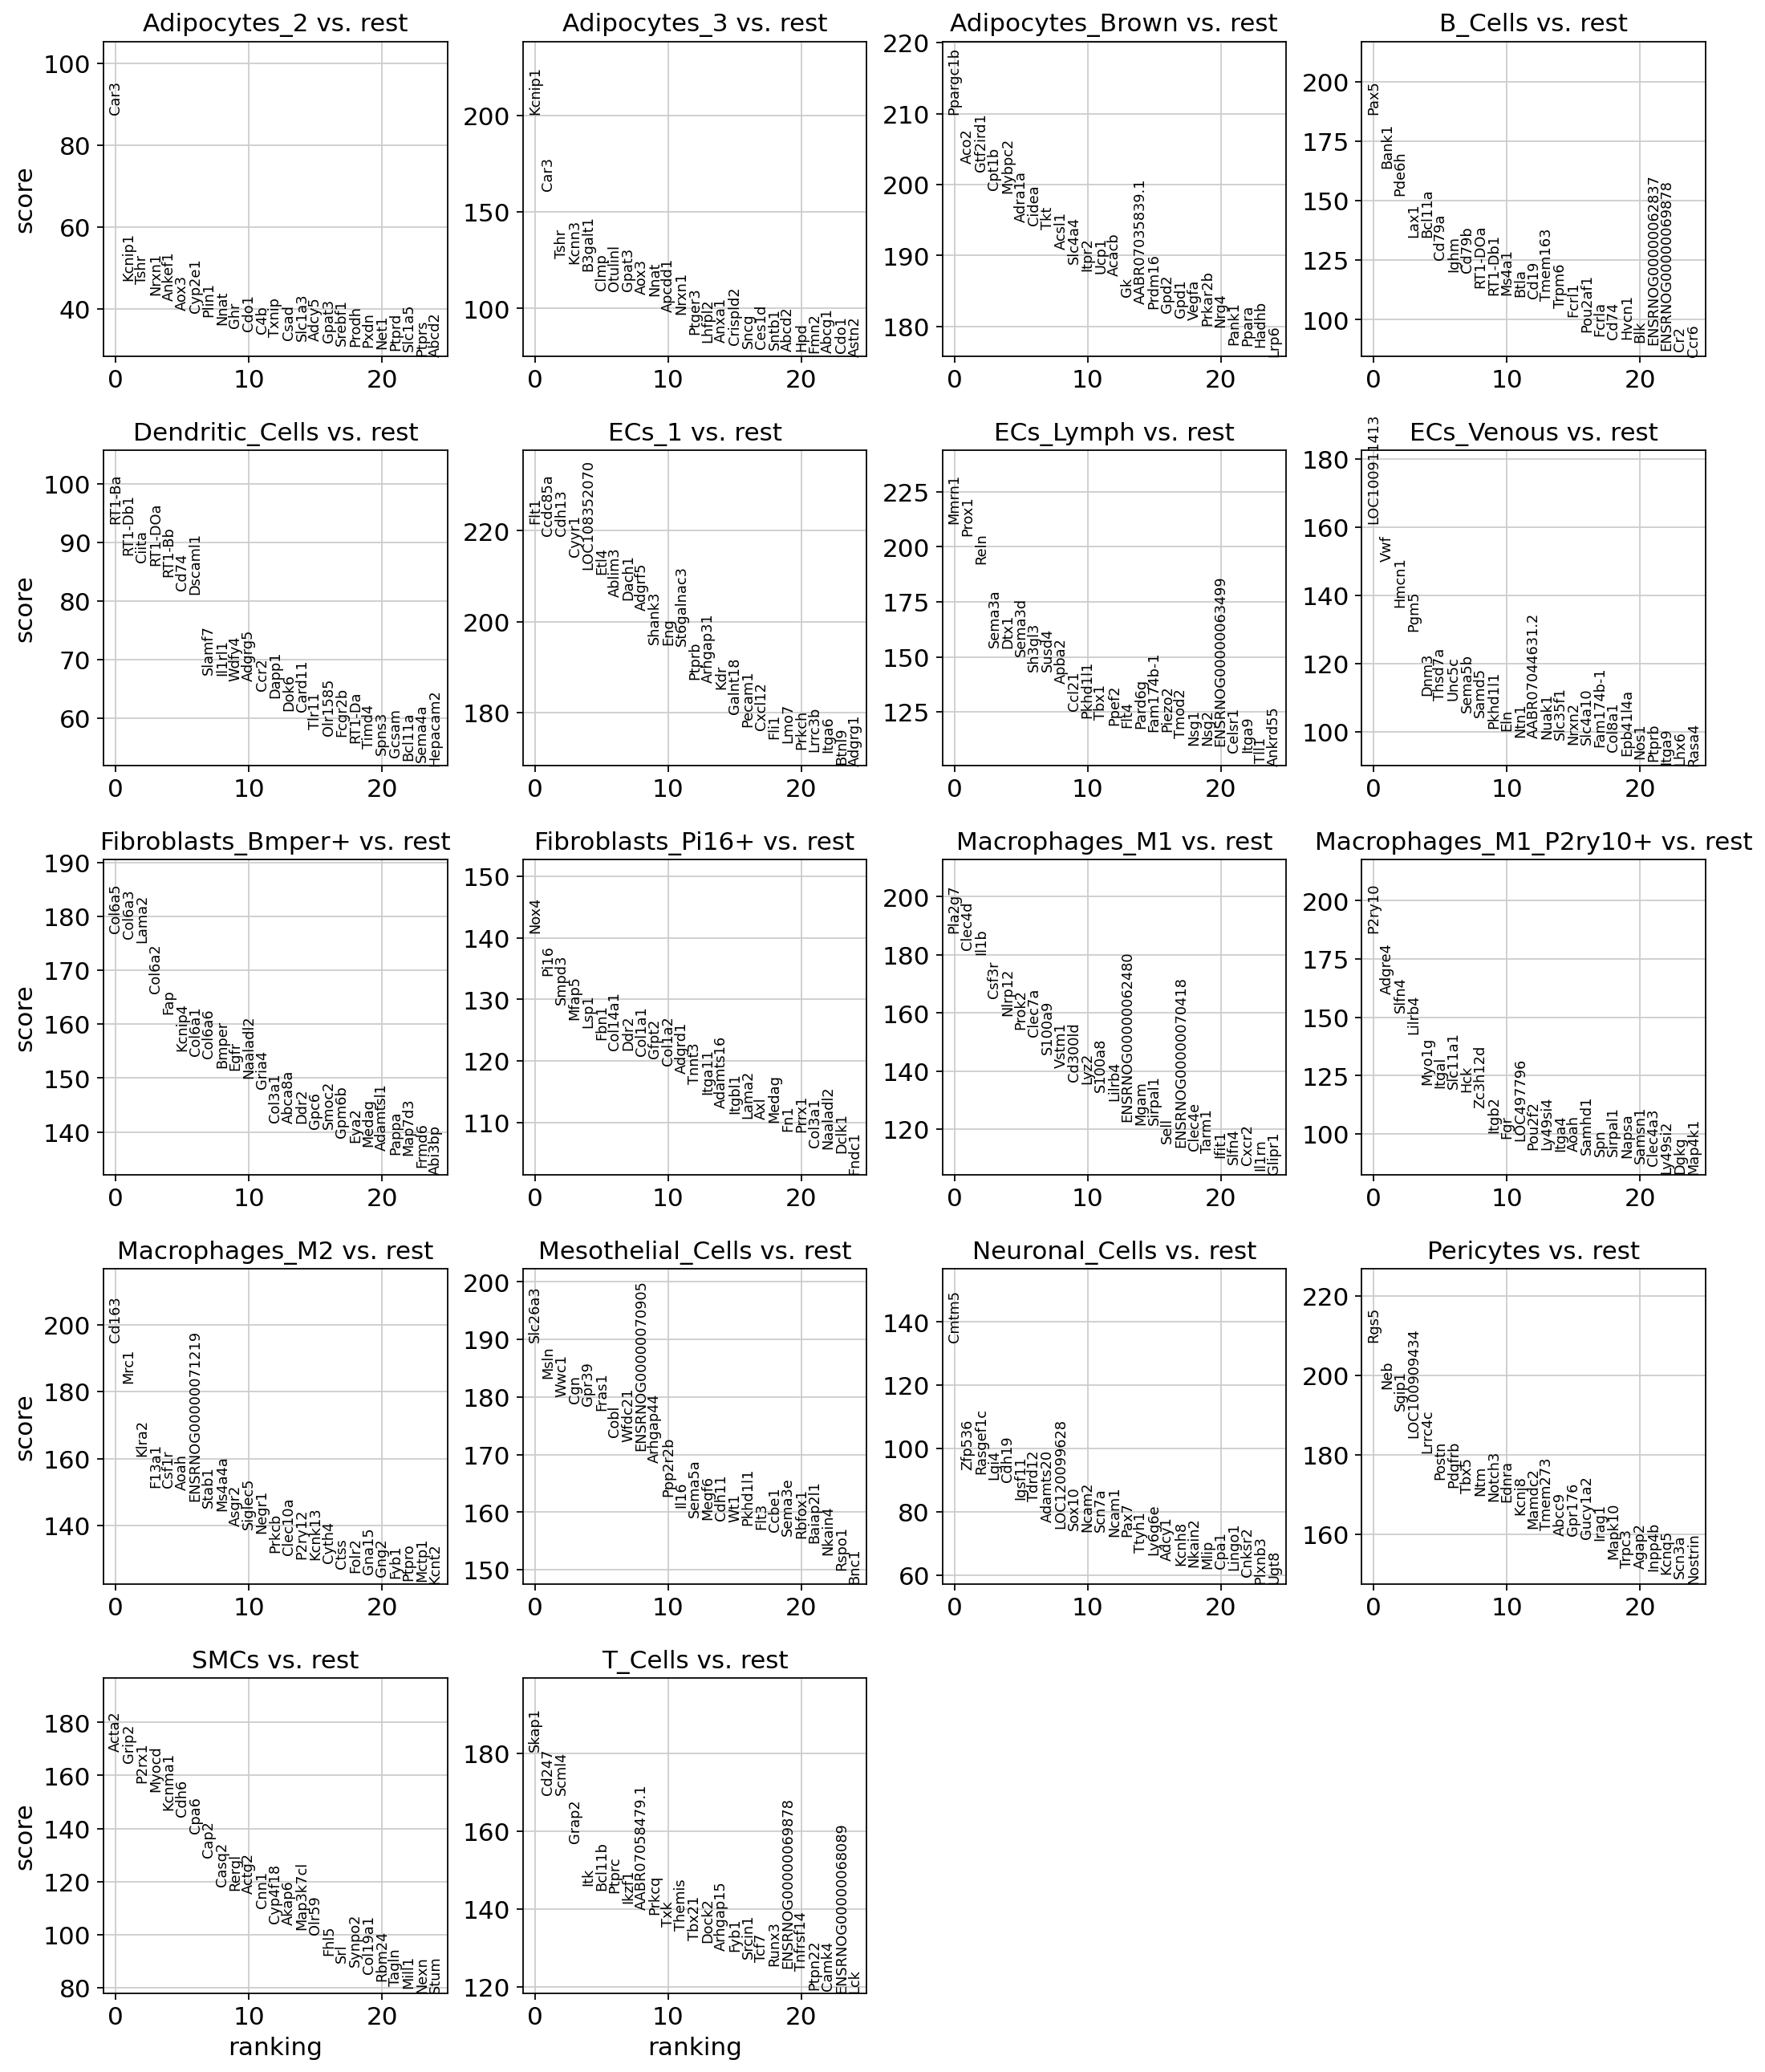

In [28]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(25).to_csv('../output/taPVAT_8W_24W_M_F_HF_CTRL_rank_genes_groups_celltype_initial.csv')

## Visualizing the location of expression of common marker genes

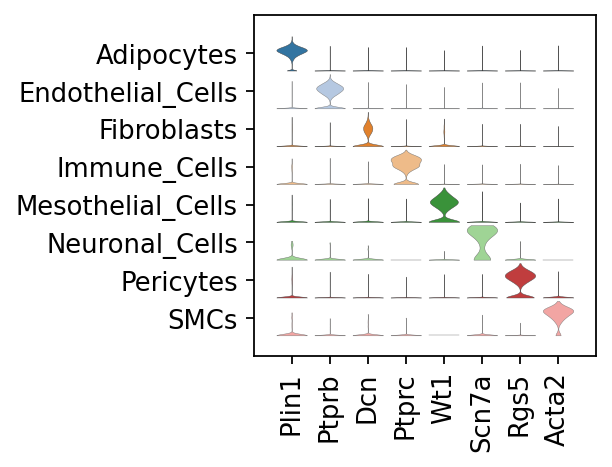

In [29]:
### Violin plot of gene expression for labeling "high-level" cell-types
mgl = ["Plin1",  #Adipocytes
       "Ptprb",  #Endothelial_Cells
       "Dcn",    #Fibroblasts
       "Ptprc",  #Immune_Cells
       "Wt1",    #Mesothelial_Cells
       "Scn7a",  #Neuronal_Cells
       "Rgs5",   #Pericytes
       "Acta2"   #SMCs
]

ax = sc.pl.stacked_violin(adata, 
                          mgl, 
                          use_raw = True,
                          groupby='celltype_broad', 
                          swap_axes = False, 
                          row_palette = 'tab20')

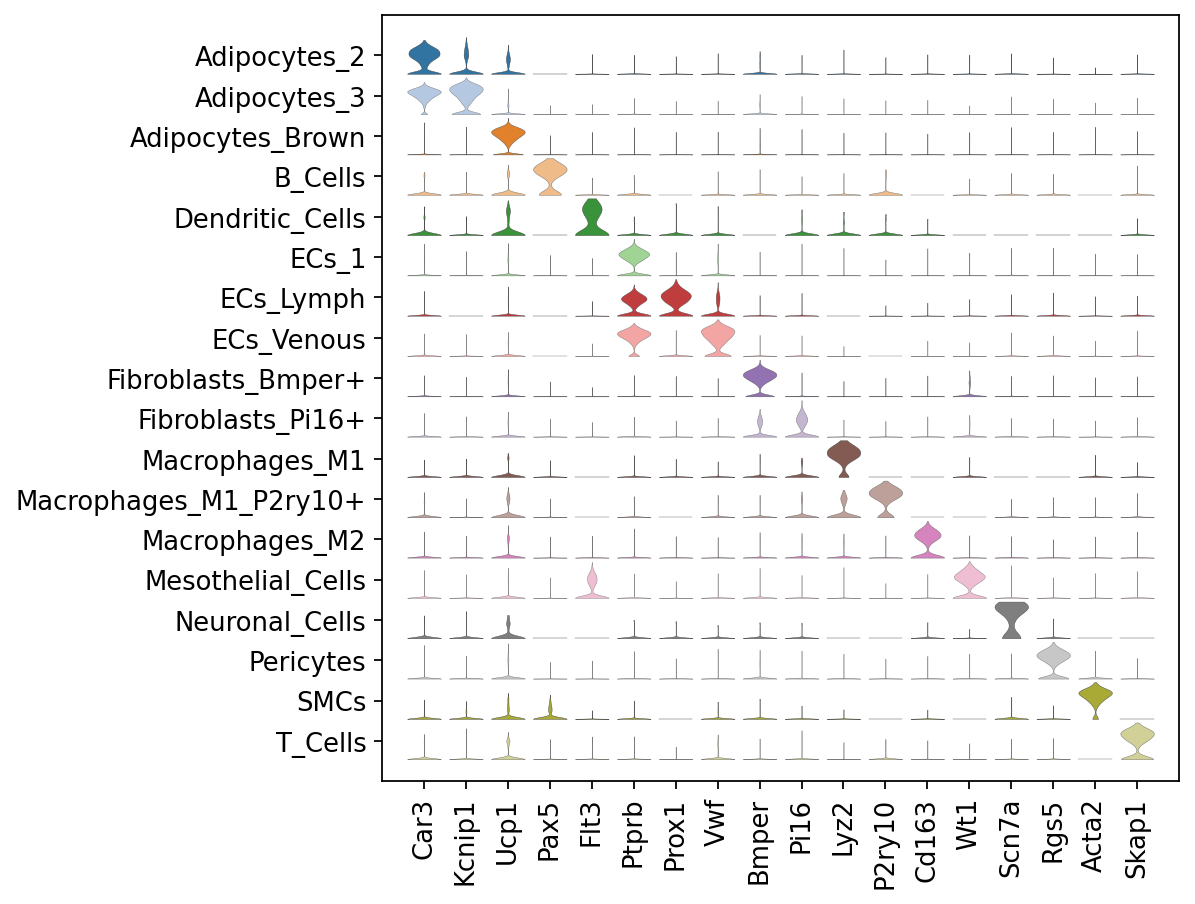

In [30]:
### Violin plot of gene expression for labeling "low-level" cell-types
mgl = ["Car3",              #Adipocytes_2 
       "Kcnip1",            #Adipocytes_3
       "Ucp1",              #Adipocytes_Brown
       "Pax5",              #B_Cells
       "Flt3",              #DCs
       "Ptprb",             #Endothelial_Cells (ECs)
       "Prox1",             #ECs_Lymph
       "Vwf",               #ECs_Venous
       "Bmper",             #Fibroblasts_Bmper+
       "Pi16",              #Fibroblasts_Pi16+
       "Lyz2",              #Macrophages_M1
       "P2ry10",            #Macrophages_M1_P2ry10+
       "Cd163",             #Macrophages_M2
       "Wt1",               #Mesothelial_Cells
       "Scn7a",             #Neuronal_Cells
       "Rgs5",              #Pericytes
       "Acta2",             #Smooth_Muscle_Cells (SMCs)
       "Skap1"              #T_Cells
]
ax = sc.pl.stacked_violin(adata, 
                          mgl, 
                          use_raw = True,
                          groupby='celltype', 
                          swap_axes = False, 
                          row_palette = 'tab20')

## Comparing our labels to labels used in other literature

In [31]:
### From Rance: https://github.com/naultran/BAT_taPVAT_snRNAseq/blob/main/PVAT_BAT_Combined/code/1_PVAT_BAT_scanpy-scvi_integration-Final.ipynb

def filter_genes_in_dict(adata, cell_type_genes_dict):
    """
    Filter genes in the cell_type_genes_dict that are not present in the adata object for each cell type.

    Parameters:
    adata (anndata.AnnData): The AnnData object containing gene expression data.
    cell_type_genes_dict (dict): A dictionary where keys are cell types and values are lists of genes.

    Returns:
    filtered_dict (dict): A filtered version of cell_type_genes_dict with only genes present in the adata.
    """
    filtered_dict = {}

    for cell_type, genes in cell_type_genes_dict.items():
        # Filter genes that are present in adata
        valid_genes = [gene for gene in genes if gene in adata.var_names]

        # Add the filtered genes to the dictionary
        filtered_dict[cell_type] = valid_genes

    return filtered_dict

In [32]:
# Load the tab-delimited file into a DataFrame
markers_mouse = pd.read_csv('../data/41586_2022_4518_MOESM5_ESM_ALL.txt', sep = '\t', index_col = 0)

# Initialize an empty dictionary
cluster_dict = {}

# Iterate through unique clusters and create a dictionary entry for each
for cluster in markers_mouse['cluster'].unique():
    # Filter the DataFrame for rows with the current cluster
    cluster_df = markers_mouse[markers_mouse['cluster'] == cluster]
    
    # Sort the cluster DataFrame by the "fold-change" column in descending order
    sorted_cluster_df = cluster_df.sort_values(by='avg_log2FC', ascending=False)
    
    # Extract the top 100 gene values for the cluster as a list
    top_genes = sorted_cluster_df['gene'].head(50).tolist()
    
    # Add the top 100 gene values list to the dictionary with the cluster as the key
    cluster_dict[cluster] = top_genes

filtered_markers = filter_genes_in_dict(adata, cluster_dict)

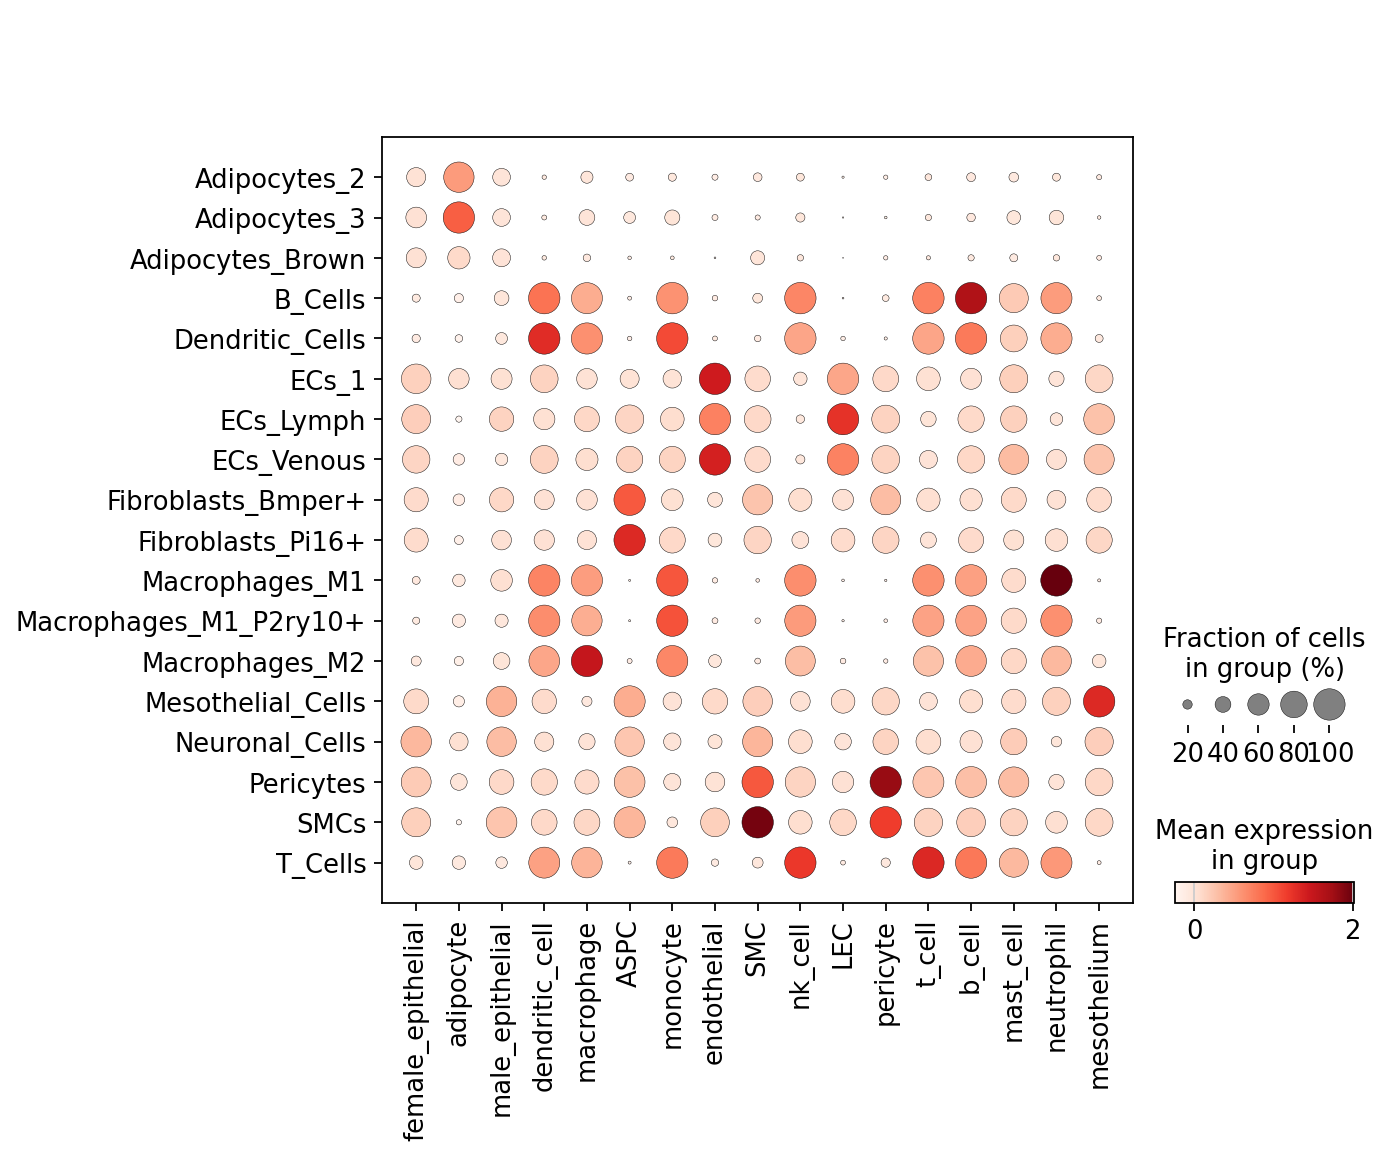

In [33]:
keys = filtered_markers.keys()

for key in keys:
    value = filtered_markers[key]
    sc.tl.score_genes(adata, value, ctrl_size=len(value), gene_pool=None, n_bins=50, score_name=key, use_raw=True)

sc.pl.dotplot(adata, list(keys), groupby='celltype', dendrogram=False)

In [34]:
# Load the tab-delimited file into a DataFrame
markers_human = pd.read_csv('../data/41586_2022_4518_MOESM4_ESM_ALL.txt', sep = '\t', index_col = 0)

# Initialize an empty dictionary
cluster_dict = {}

# Iterate through unique clusters and create a dictionary entry for each
for cluster in markers_human['cluster'].unique():
    # Filter the DataFrame for rows with the current cluster
    cluster_df = markers_human[markers_human['cluster'] == cluster]
    
    # Sort the cluster DataFrame by the "fold-change" column in descending order
    sorted_cluster_df = cluster_df.sort_values(by='avg_log2FC', ascending=False)
    
    # Extract the top 100 gene values for the cluster as a list
    top_genes = sorted_cluster_df['gene'].head(50).tolist()
    
    # Add the top 100 gene values list to the dictionary with the cluster as the key
    cluster_dict[cluster] = [word.capitalize() for word in top_genes]

filtered_markers = filter_genes_in_dict(adata, cluster_dict)

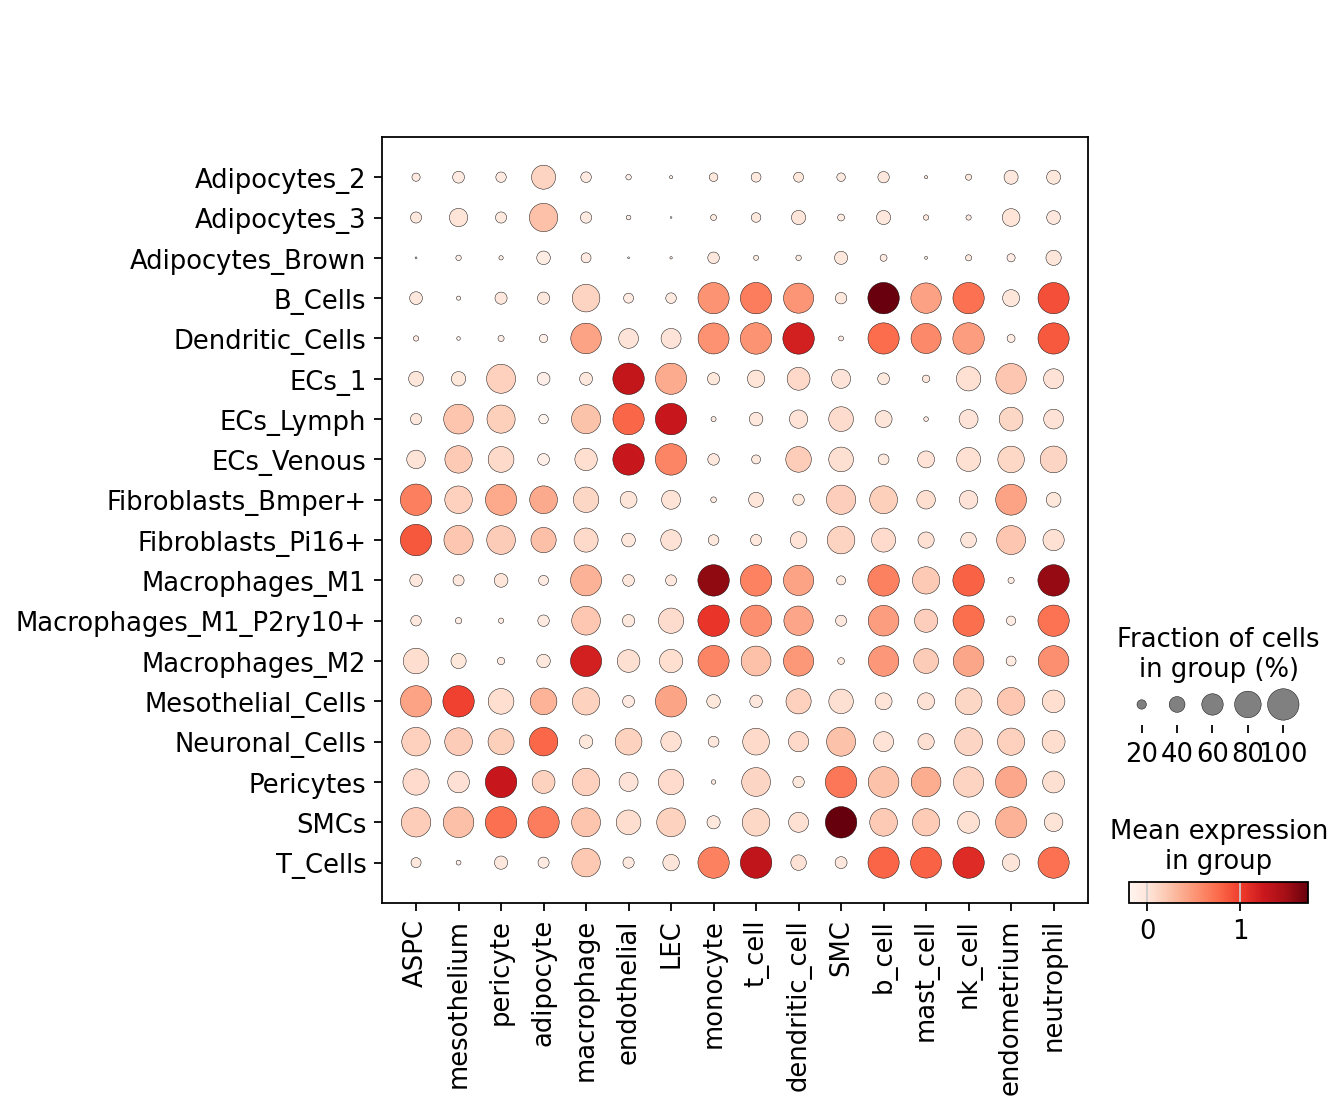

In [35]:
keys = filtered_markers.keys()

for key in keys:
    value = filtered_markers[key]
    sc.tl.score_genes(adata, value, ctrl_size=len(value), gene_pool=None, n_bins=50, score_name=key, use_raw=True)

sc.pl.dotplot(adata, list(keys), groupby='celltype', dendrogram=False)

In [36]:
# Load the tab-delimited file into a DataFrame
markers_human_BAT = pd.read_csv('../data/Sun_markers_humanBAT.txt', sep = '\t', index_col = 0)

# Initialize an empty dictionary
cluster_dict = {}

# Iterate through unique clusters and create a dictionary entry for each
for cluster in markers_human_BAT['cluster'].unique():
    # Filter the DataFrame for rows with the current cluster
    cluster_df = markers_human_BAT[markers_human_BAT['cluster'] == cluster]
    
    # Sort the cluster DataFrame by the "fold-change" column in descending order
    sorted_cluster_df = cluster_df.sort_values(by='avg_logFC', ascending=False)
    
    # Extract the top 100 gene values for the cluster as a list
    top_genes = sorted_cluster_df['gene'].head(50).tolist()
    
    # Add the top 100 gene values list to the dictionary with the cluster as the key
    cluster_dict[cluster] = [word.capitalize() for word in top_genes]

filtered_markers = filter_genes_in_dict(adata, cluster_dict)

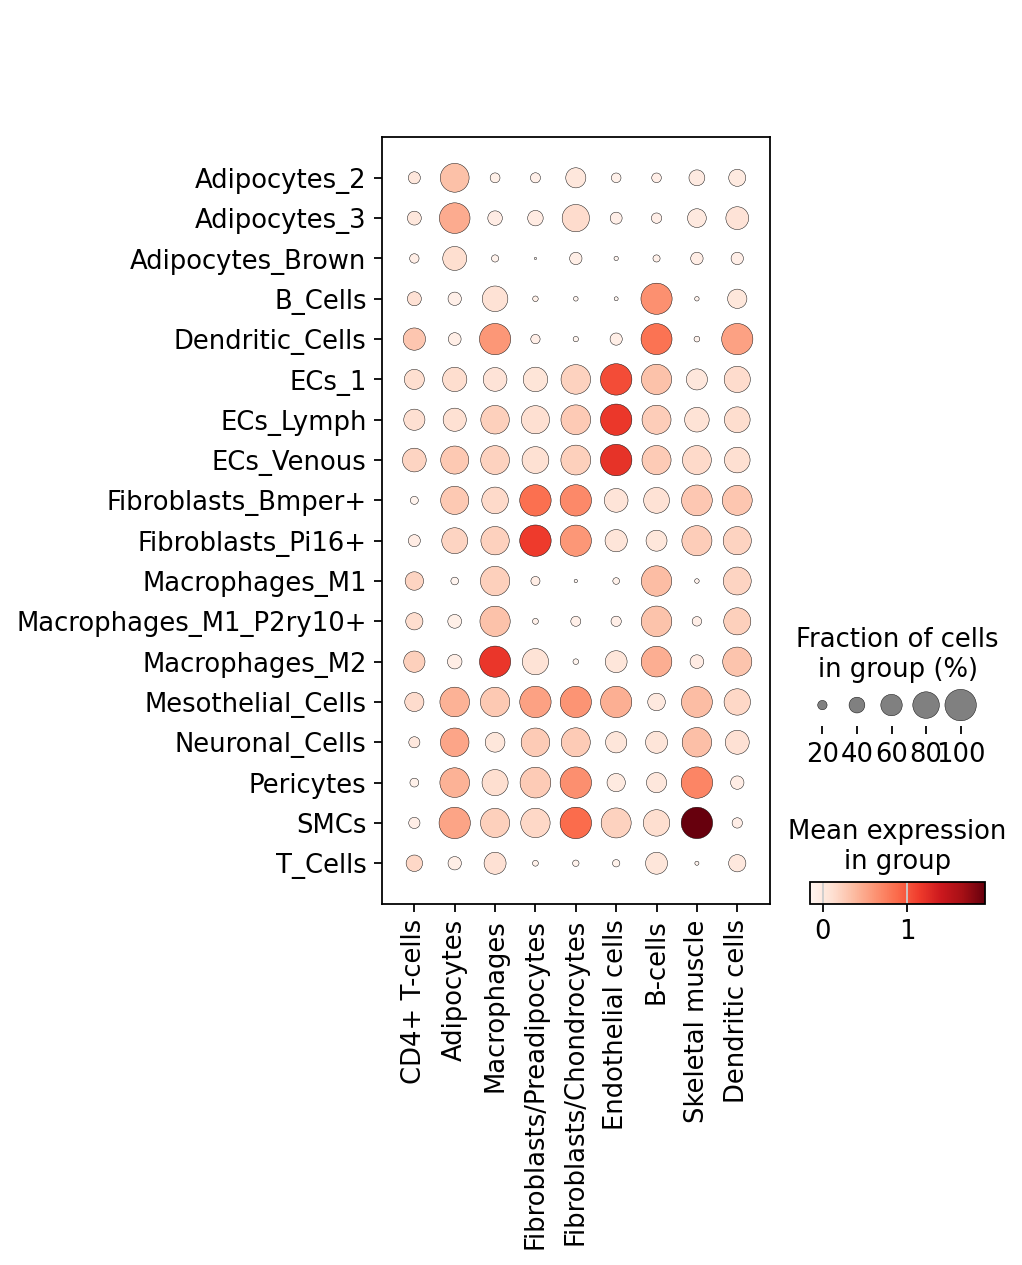

In [37]:
keys = filtered_markers.keys()

for key in keys:
    value = filtered_markers[key]
    sc.tl.score_genes(adata, value, ctrl_size=len(value), gene_pool=None, n_bins=50, score_name=key, use_raw=True)

sc.pl.dotplot(adata, list(keys), groupby='celltype', dendrogram=False)

## Save the annotated data

In [38]:
adata.write_h5ad('../data/taPVAT_combined_annotated.h5ad')